# Quiz 5

Estudiantes:

- Alonso Araya
- Pedro Soto
- Sofia Oviedo

# Load the data

In [2]:
import pandas as pd

#data frame
sms_df = pd.read_table('SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])

display(sms_df.head())


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Install BERT

In [3]:
%pip install transformers torch

# Login to HF

In [ ]:
from huggingface_hub import login

login(token='')

# Load BERT

In [5]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [6]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used: ", device)
model.to(device)

Device used:  cuda


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

# Compute embeddings

In [7]:
import torch


def compute_bert_embeddings(text_snippets, model):
    encoded_input = tokenizer(text_snippets, padding=True, truncation=True, return_tensors='pt')
    # Move encoded_input to the same device as the model
    encoded_input = {key: value.to(model.device) for key, value in encoded_input.items()}
    with torch.no_grad():
        model_output = model(**encoded_input)
    # Use the embeddings of the [CLS] token
    embeddings = model_output.last_hidden_state[:, 0, :]
    #print("embeddings shape \n", embeddings.shape)
    return embeddings


sms_df['embeddings'] = sms_df['message'].apply(lambda x: compute_bert_embeddings([x], model).squeeze())

display(sms_df.head())

,label,message,embeddings
0,ham,"Go until jurong point, crazy.. Available only ...","[tensor(-0.1513, device='cuda:0'), tensor(-0.3..."
1,ham,Ok lar... Joking wif u oni...,"[tensor(-0.1238, device='cuda:0'), tensor(0.34..."
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[tensor(-0.5031, device='cuda:0'), tensor(-0.2..."
3,ham,U dun say so early hor... U c already then say...,"[tensor(0.0646, device='cuda:0'), tensor(0.576..."
4,ham,"Nah I don't think he goes to usf, he lives aro...","[tensor(0.0947, device='cuda:0'), tensor(0.389..."


In [8]:
#store the embedding in a tensor
embeddings_tensor = torch.stack(sms_df['embeddings'].tolist())
print("Embeddings tensor shape: ", embeddings_tensor.shape)
#convert the labels to numerical values in a tensor
label_mapping = {'ham': 0, 'spam': 1}
numerical_labels = sms_df['label'].map(label_mapping)
labels_tensor = torch.tensor(numerical_labels.tolist())
print("labels 0 ", (labels_tensor == 0).sum())
print("labels 1 ", (labels_tensor == 1).sum())

Embeddings tensor shape:  torch.Size([5572, 768])
labels 0  tensor(4825)
labels 1  tensor(747)


# Split the dataset (70% Train, 15% Validation, 15% Test)

In [9]:
from sklearn.model_selection import train_test_split

# Primero dividir en 70% entrenamiento y 30% restante
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    embeddings_tensor, labels_tensor, test_size=0.30, random_state=42, stratify=labels_tensor
)

# Luego dividir el 30% restante en 15% validación y 15% prueba
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Entrenamiento: {X_train_full.shape[0]} muestras ({X_train_full.shape[0] / len(embeddings_tensor) * 100:.1f}%)")
print(f"Validación: {X_val.shape[0]} muestras ({X_val.shape[0] / len(embeddings_tensor) * 100:.1f}%)")
print(f"Prueba: {X_test.shape[0]} muestras ({X_test.shape[0] / len(embeddings_tensor) * 100:.1f}%)")

# Verificar distribución de clases
print("\nDistribución de clases:")
print(f"Entrenamiento - Ham: {(y_train_full == 0).sum()}, Spam: {(y_train_full == 1).sum()}")
print(f"Validación - Ham: {(y_val == 0).sum()}, Spam: {(y_val == 1).sum()}")
print(f"Prueba - Ham: {(y_test == 0).sum()}, Spam: {(y_test == 1).sum()}")

Entrenamiento: 3900 muestras (70.0%)
Validación: 836 muestras (15.0%)
Prueba: 836 muestras (15.0%)

Distribución de clases:
Entrenamiento - Ham: 3377, Spam: 523
Validación - Ham: 724, Spam: 112
Prueba - Ham: 724, Spam: 112


# 1. (30 puntos) Para el dataset SMS_dataset disponible, implemente los siguientes modelos de clasificacion

```
a) Entrene una red neuronal con 2 variantes de arquitectura a definir por usted. Justifique las 2 variantes
y entrene ambos modelos, muestre sus curvas de aprendizaje para una particion de datos de
entrenamiento (70%) y validacion (15%) luego de la calibracion de los principales hiperparametros.
Evalue el error con una particion aleatoria de prueba (15%) Comente los resultados.
```

In [10]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns

## Modelos propuestos

In [11]:
class SpamClassifierV1(nn.Module):
    def __init__(self, input_dim=768):
        super(SpamClassifierV1, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)


class SpamClassifierV2(nn.Module):
    def __init__(self, input_dim=768):
        super(SpamClassifierV2, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

### Primer Modelo

Para el primer modelo propuesto "SpamClassifierV1", este representa el modelo más profundo. Este busca reducir la dimensionalidad escalonada desde la entrada de 768 pasando por 512, 256, 128 y 1, esto puede ayudar a que el modelo aprenda representaciones más complejas, y reducir la dimensionalidad gradualmente puede evitar perder información abruptamente.

En el caso del dropout se utilizan valores de 0,5 y 0,3, esto permite regularizar correctamente el modelo y prevenir el overfitting, se reduce al final con 0,3 para poder preservar la mayor cantidad de información antes de realizar la clasificacion.

Esta utiliza cuatro capas y es capaz de poder capturar mejor los patrones complejos del set de datos y valores no lineales de los embeddings producidos por BERT. Sin embargo, puede utilizar un poco más de recursos al ser más profundo.

### Segundo Modelo

En el segundo modelo que se llama "SpamClassifierV2", este tiene un perfil más pequeño pero más agresivo, ya que va desde la dimension de entrada de 768 hasta 256 y 64. Tiene también menos capas comparado con el modelo anterior y este va siendo un modelo más pequeño con el fin de que sea eficiente a nivel computacional y comparar si existe un verdadero beneficio al usar algo más escalonado y profundo como lo es el modelo V1 en contra de este modelo que es un poco más pequeño y agresivo.

Ademas de eso tiene parametros como el dropout en 0,3 siendo un poco más balanceado para perder menos información y ser consistente, esto puede ayudar a prevenir overfitting y preservar la mayor cantidad de información durante todo el modelo. Al ser más pequeño también podria ayudar a que no se sobreajuste y pueda generalizar con buenos resultados a un menor costo y complejidad; sin embargo, al no ser tan profundo tiene el riesgo de caer en underfitting.

En general ambos utilizan la funcion de activacion ReLu conocida por ser más eficiente a nivel computacional por su naturaleza linear y que puede ayudar a mitigar el problema de gradientes desvanecientes, ayudando a que se puedan crear redes más profundas, también tiene la ventaja dada sus propiedades no lineares ayuda a capturar estos mismos patrones en los datos.

También se utiliza la función sigmoidal dado que es una clasificacion binaria y nos puede dar resultados de 0 y 1, además en las proximas celdas de entrenamiento se utiliza `BCELoss`, que necesita de este formato para operar.

## Logica de Entrenamiento

In [12]:
def train_model(model, train_loader, val_loader, epochs=50, lr=0.001, weight_decay=0.01):
    """
    Entrena un modelo de clasificación binaria para detección de spam con validación cruzada.

    Parámetros
    ----------
    model : torch.nn.Module
        Red neuronal a entrenar (SpamClassifierV1, SpamClassifierV2, etc.).
        Debe tener salida sigmoid para clasificación binaria.

    train_loader : torch.utils.data.DataLoader
        DataLoader con datos de entrenamiento. Debe retornar (features, labels)
        donde features son embeddings BERT (shape: [batch_size, 768]) y
        labels son enteros {0: ham, 1: spam}.

    val_loader : torch.utils.data.DataLoader
        DataLoader con datos de validación. Mismo formato que train_loader.
        Usado para evaluación independiente y selección del mejor modelo.

    epochs : int, optional, default=50
        Número máximo de épocas de entrenamiento. El entrenamiento puede
        detenerse antes si se detectan problemas de convergencia.

    lr : float, optional, default=0.001
        Learning rate para el optimizador Adam. Controla el tamaño de paso
        en la actualización de parámetros. Valores típicos: [0.0001, 0.01].

    weight_decay : float, optional, default=0.01
        Coeficiente de regularización L2 aplicado por el optimizador Adam.
        Previene sobreajuste penalizando parámetros grandes. Valores típicos: [0.0, 0.1].

    Retorna
    -------
    dict
        Diccionario con el historial completo de entrenamiento:

        - 'train_losses' : List[float]
            Pérdida BCE promedio por época en conjunto de entrenamiento.
        - 'val_losses' : List[float]
            Pérdida BCE promedio por época en conjunto de validación.
        - 'train_accuracies' : List[float]
            Accuracy (exactitud) por época en conjunto de entrenamiento.
        - 'val_accuracies' : List[float]
            Accuracy por época en conjunto de validación.
        - 'train_f1_scores' : List[float]
            F1-score por época en conjunto de entrenamiento.
        - 'val_f1_scores' : List[float]
            F1-score por época en conjunto de validación.
        - 'best_val_f1' : float
            Mejor F1-score alcanzado en validación durante todo el entrenamiento.

    """
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_f1_scores, val_f1_scores = [], []

    best_val_f1 = 0
    best_model_state = None

    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        train_loss = 0
        train_predictions = []
        train_targets = []

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predictions = (outputs > 0.5).float()
            train_predictions.extend(predictions.cpu().numpy().flatten())
            train_targets.extend(batch_y.cpu().numpy().flatten())

        # Validación
        model.eval()
        val_loss = 0
        val_predictions = []
        val_targets = []

        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device).float().unsqueeze(1)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

                predictions = (outputs > 0.5).float()
                val_predictions.extend(predictions.cpu().numpy().flatten())
                val_targets.extend(batch_y.cpu().numpy().flatten())

        # Calcular métricas
        train_acc = np.mean(np.array(train_predictions) == np.array(train_targets))
        val_acc = np.mean(np.array(val_predictions) == np.array(val_targets))

        train_f1 = f1_score(train_targets, train_predictions)
        val_f1 = f1_score(val_targets, val_predictions)

        # Guardar métricas
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

        # Guardar mejor modelo
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict().copy()

        if (epoch + 1) % 10 == 0:
            print(f'Época {epoch + 1}/{epochs}: '
                  f'Train Loss: {train_losses[-1]:.4f}, '
                  f'Val Loss: {val_losses[-1]:.4f}, '
                  f'Val F1: {val_f1:.4f}')

    # Restaurar mejor modelo
    model.load_state_dict(best_model_state)

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'train_f1_scores': train_f1_scores,
        'val_f1_scores': val_f1_scores,
        'best_val_f1': best_val_f1
    }

La funcion train_model permite entrenar un modelo, esta recibe como parametros el modelo, datos de entrenamiento y validacion, asi como el learning rate y regularizacion l2.

Esta funcion transfiere el modelo al device utilizado para asegurar que esté utilizando la GPU. Se utiliza la funcion BCELoss que es una de las más adecuadas para clasificacion binaria, ya que mide la divergencia entre probabilidades que salieron del modelo y se ajusta perfectamente al modelo, ya que utiliza la funcion sigmoidal y por ende etiquetas de 0 y 1.

Se utiliza Adam como optimizador, ya que puede ajustar adaptativamente parametros como el learning rate, combina caracteristicas de RMSProp y SGD con momentum, asi como una convergencia más estable y rapida en los modelos profundos, por lo que es una buena funcion segura e inicial por utilizar.

También la funcion almacena todas las metricas como las perdidas de entrenamiento y validacion, asi como su accuracy y F1 Score para las particiones, finalmente evaluando cuál fue el mejor modelo que obtuvo el mejor F1.

La funcion entrena el modelo en varios pasos, primero se limpian los gradientes con `zero_grad`, después se hace un forward pass del modelo, se calculan las perdidas, se hace el cálculo de gradiente y finalmente se optimizan los parametros. En general también se toma en cuenta pasar los valores al dispositivo ajustado para ser usado en la GPU o en caso de usar librerias como numpy se pasa a CPU. Durante el entrenamiento se convierten las probabilidades en predicciones binarias y se guardan para generar las metricas.

En cuanto a la fase de validacion se activa el modo por medio de `model.eval`, esta funcion desactiva el dropout y se ajusta para ser más deterministico para la validacion. Por medio de `torch.grad` se desactiva el cálculo de gradientes y solo se realiza forward pass, estos pasos ayudan a reducir el uso de recursos, ya que no se necesitan nuevamente algunos pasos. Estas predicciones de las validaciones se van a guardar para el cálculo de las metricas.

Se utilizó además un sistema de checkpointing el cual utiliza el F1 Score de la validacion y se guarda una copia del mejor modelo por el momento.

En el paso final se generan las metricas por medio de las predicciones y targets guardados en los pasos de entrenamiento y validacion, se generaron metricas de promedio de las perdidas, accuracy y F1 Score para el entrenamiento y validacion, todas estas son retornadas al final de la funcion.

In [13]:
from torch.utils.data import DataLoader, TensorDataset

# Procesamiento en lotes y Gestion de Datos
batch_size = 32

train_dataset = TensorDataset(X_train_full, y_train_full)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Optimizacion de Parametros

In [14]:
# Definir hiperparámetros a probar
learning_rates = [0.001, 0.0005]
weight_decays = [0.01, 0.001]
epochs = 50

best_params_v1 = {'lr': None, 'wd': None, 'score': 0}
best_params_v2 = {'lr': None, 'wd': None, 'score': 0}

print("\nCalibrando Modelo V1 (Red Profunda)...")
for lr in learning_rates:
    for wd in weight_decays:
        print(f"  Probando lr={lr}, weight_decay={wd}")
        model_v1 = SpamClassifierV1()
        history = train_model(model_v1, train_loader, val_loader,
                              epochs=30, lr=lr, weight_decay=wd)

        if history['best_val_f1'] > best_params_v1['score']:
            best_params_v1 = {'lr': lr, 'wd': wd, 'score': history['best_val_f1']}

print(f"  Mejor V1: lr={best_params_v1['lr']}, wd={best_params_v1['wd']}, F1={best_params_v1['score']:.4f}")

print("\nCalibrando Modelo V2 (Red Simple)...")
for lr in learning_rates:
    for wd in weight_decays:
        print(f"  Probando lr={lr}, weight_decay={wd}")
        model_v2 = SpamClassifierV2()
        history = train_model(model_v2, train_loader, val_loader,
                              epochs=30, lr=lr, weight_decay=wd)

        if history['best_val_f1'] > best_params_v2['score']:
            best_params_v2 = {'lr': lr, 'wd': wd, 'score': history['best_val_f1']}

print(f"  Mejor V2: lr={best_params_v2['lr']}, wd={best_params_v2['wd']}, F1={best_params_v2['score']:.4f}")


Calibrando Modelo V1 (Red Profunda)...
  Probando lr=0.001, weight_decay=0.01
Época 10/30: Train Loss: 0.0548, Val Loss: 0.0407, Val F1: 0.9444
Época 20/30: Train Loss: 0.0577, Val Loss: 0.0547, Val F1: 0.9356
Época 30/30: Train Loss: 0.0494, Val Loss: 0.0349, Val F1: 0.9493
  Probando lr=0.001, weight_decay=0.001
Época 10/30: Train Loss: 0.0359, Val Loss: 0.0267, Val F1: 0.9725
Época 20/30: Train Loss: 0.0277, Val Loss: 0.0262, Val F1: 0.9643
Época 30/30: Train Loss: 0.0255, Val Loss: 0.0287, Val F1: 0.9589
  Probando lr=0.0005, weight_decay=0.01
Época 10/30: Train Loss: 0.0465, Val Loss: 0.0302, Val F1: 0.9589
Época 20/30: Train Loss: 0.0467, Val Loss: 0.0383, Val F1: 0.9493
Época 30/30: Train Loss: 0.0419, Val Loss: 0.0653, Val F1: 0.9179
  Probando lr=0.0005, weight_decay=0.001
Época 10/30: Train Loss: 0.0305, Val Loss: 0.0313, Val F1: 0.9630
Época 20/30: Train Loss: 0.0217, Val Loss: 0.0377, Val F1: 0.9630
Época 30/30: Train Loss: 0.0148, Val Loss: 0.0387, Val F1: 0.9585
  Mejor 

En la logica de arriba se realiza el entrenamiento en sí de los modelos, para este efecto también se adecuó el codigo para poder realizar una optimizacion de parametros pequeña, se generó un rango de learning rates y weight decays a utilizar.

Se escogio ese rango de learning rate debido a qué 0.001 es estandar a utilizar con Adam y proporciona un buen balance, el valor de 0.0005 es un poco más conservador y evita mucho más el sobreajuste, estos dos valores proporcionan un punto medio para optimizar el modelo.

En cuanto al weight decay, el valor de 0.01 presenta una regularizacion un poco más alta lo que podria evitar de gran manera el overfitting, en cuanto a 0.001 da más flexibilidad al modelo y entre estos valores se puede variar el ajuste y la capacidad de generalizacion del modelo.

Esta funcion finalmente tiene como salida los mejores parametros por cada arquitectura, asi como sus F1 Score, también se puede observar las perdidas y F1 por cada grupo de epochs que paso, observando la evolucion del entrenamiento. Se guardan los mejores parametros para realizar el entrenamiento final con estas combinaciones por arquitectura.

In [15]:
# Entrenar Modelo V1 con mejores parámetros
print("Entrenando Modelo V1 con mejores hiperparámetros...")
model_v1_final = SpamClassifierV1()
history_v1 = train_model(model_v1_final, train_loader, val_loader,
                         epochs=epochs,
                         lr=best_params_v1['lr'],
                         weight_decay=best_params_v1['wd'])

# Entrenar Modelo V2 con mejores parámetros
print("\nEntrenando Modelo V2 con mejores hiperparámetros...")
model_v2_final = SpamClassifierV2()
history_v2 = train_model(model_v2_final, train_loader, val_loader,
                         epochs=epochs,
                         lr=best_params_v2['lr'],
                         weight_decay=best_params_v2['wd'])

Entrenando Modelo V1 con mejores hiperparámetros...
Época 10/50: Train Loss: 0.0229, Val Loss: 0.0301, Val F1: 0.9550
Época 20/50: Train Loss: 0.0226, Val Loss: 0.0277, Val F1: 0.9596
Época 30/50: Train Loss: 0.0228, Val Loss: 0.0511, Val F1: 0.9533
Época 40/50: Train Loss: 0.0251, Val Loss: 0.0408, Val F1: 0.9581
Época 50/50: Train Loss: 0.0099, Val Loss: 0.0354, Val F1: 0.9596

Entrenando Modelo V2 con mejores hiperparámetros...
Época 10/50: Train Loss: 0.0256, Val Loss: 0.0306, Val F1: 0.9502
Época 20/50: Train Loss: 0.0123, Val Loss: 0.0323, Val F1: 0.9593
Época 30/50: Train Loss: 0.0116, Val Loss: 0.0377, Val F1: 0.9589
Época 40/50: Train Loss: 0.0080, Val Loss: 0.0372, Val F1: 0.9636
Época 50/50: Train Loss: 0.0059, Val Loss: 0.0445, Val F1: 0.9498


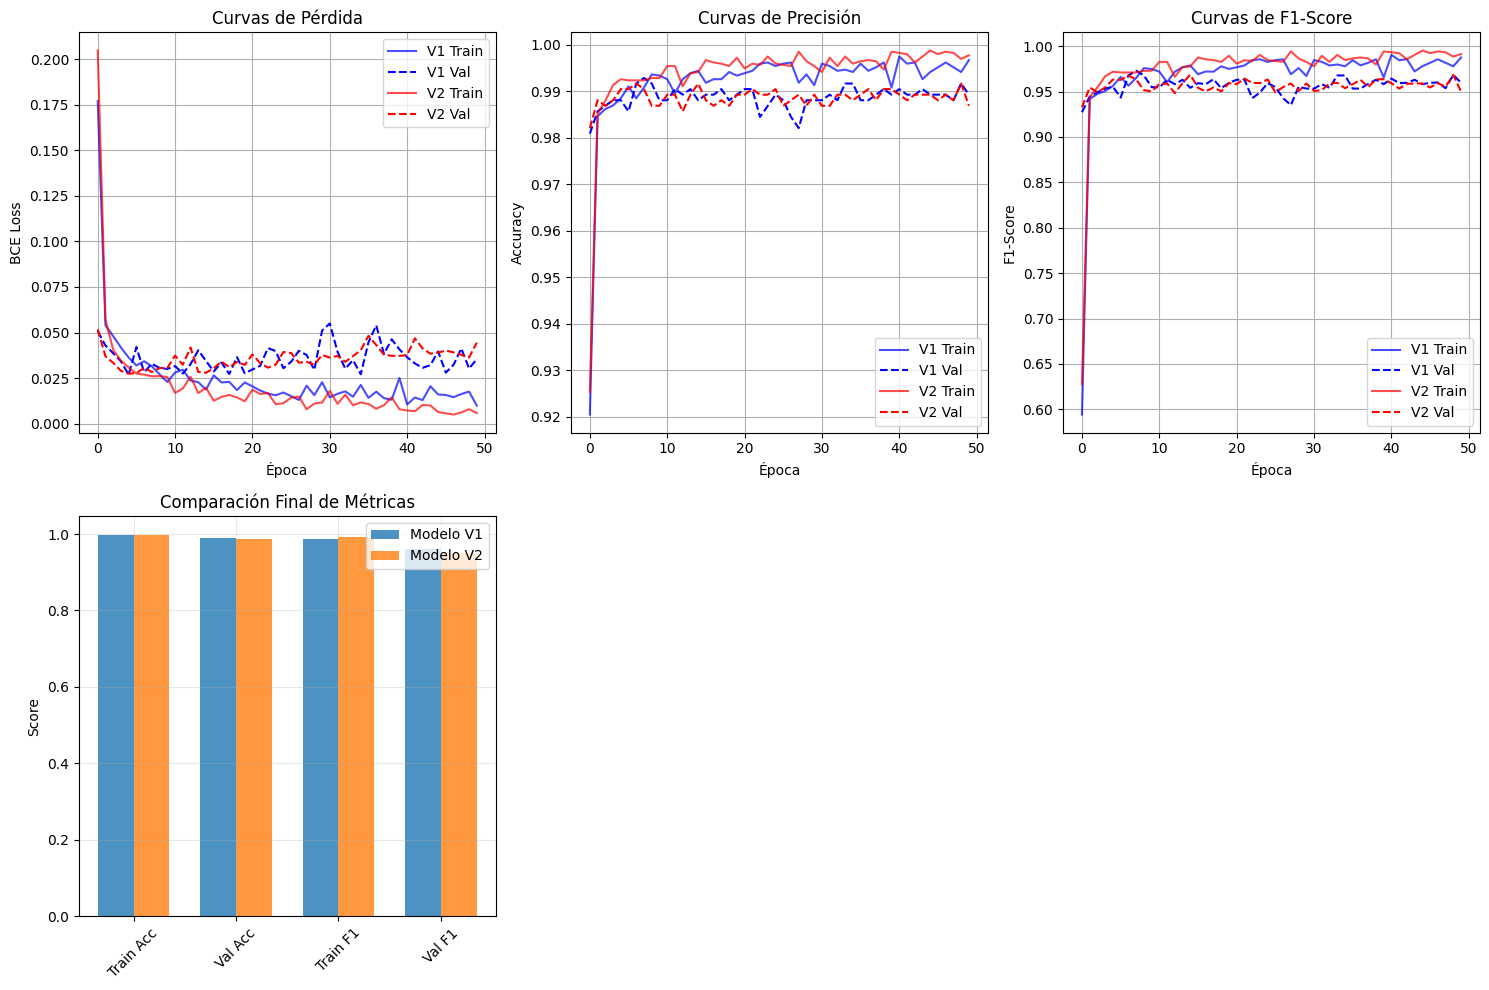

In [16]:
plt.figure(figsize=(15, 10))

# Curvas de pérdida
plt.subplot(2, 3, 1)
plt.plot(history_v1['train_losses'], label='V1 Train', color='blue', alpha=0.7)
plt.plot(history_v1['val_losses'], label='V1 Val', color='blue', linestyle='--')
plt.plot(history_v2['train_losses'], label='V2 Train', color='red', alpha=0.7)
plt.plot(history_v2['val_losses'], label='V2 Val', color='red', linestyle='--')
plt.title('Curvas de Pérdida')
plt.xlabel('Época')
plt.ylabel('BCE Loss')
plt.legend()
plt.grid(True)

# Curvas de precisión
plt.subplot(2, 3, 2)
plt.plot(history_v1['train_accuracies'], label='V1 Train', color='blue', alpha=0.7)
plt.plot(history_v1['val_accuracies'], label='V1 Val', color='blue', linestyle='--')
plt.plot(history_v2['train_accuracies'], label='V2 Train', color='red', alpha=0.7)
plt.plot(history_v2['val_accuracies'], label='V2 Val', color='red', linestyle='--')
plt.title('Curvas de Precisión')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Curvas de F1-Score
plt.subplot(2, 3, 3)
plt.plot(history_v1['train_f1_scores'], label='V1 Train', color='blue', alpha=0.7)
plt.plot(history_v1['val_f1_scores'], label='V1 Val', color='blue', linestyle='--')
plt.plot(history_v2['train_f1_scores'], label='V2 Train', color='red', alpha=0.7)
plt.plot(history_v2['val_f1_scores'], label='V2 Val', color='red', linestyle='--')
plt.title('Curvas de F1-Score')
plt.xlabel('Época')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)

# Comparación final de métricas
plt.subplot(2, 3, 4)
metrics = ['Train Acc', 'Val Acc', 'Train F1', 'Val F1']
v1_final_metrics = [history_v1['train_accuracies'][-1], history_v1['val_accuracies'][-1],
                    history_v1['train_f1_scores'][-1], history_v1['val_f1_scores'][-1]]
v2_final_metrics = [history_v2['train_accuracies'][-1], history_v2['val_accuracies'][-1],
                    history_v2['train_f1_scores'][-1], history_v2['val_f1_scores'][-1]]

x = np.arange(len(metrics))
width = 0.35
plt.bar(x - width / 2, v1_final_metrics, width, label='Modelo V1', alpha=0.8)
plt.bar(x + width / 2, v2_final_metrics, width, label='Modelo V2', alpha=0.8)
plt.title('Comparación Final de Métricas')
plt.ylabel('Score')
plt.xticks(x, metrics, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Basándonos en el entrenamiento hecho con los parametros optimizados se generan las curvas de perdida, precision, F1 Score y comparacion entre ambos modelos. Esto nos permite ver de una mejor manera la evolucion de cada modelo durante los epochs.

En cuanto a la curva de perdida se puede observar como con pocos epochs rapidamente se reduce la perdida, además se observa una cierta estabilidad después del epoch 10, las cuales se mantienen entre 0,2 y 0,4. Al ver las curvas de validacion estas tienden a estar cerca de las de entrenamiento, lo que dice que podrian tener un sobreajuste minimo y se obtiene una perdida baja lo que indica que el modelo tiene un buen ajuste.

En el accuracy se observa como antes de la mitad de los epochs realizados ya se obtiene resultados de 99%, el modelo V1 tiene una ligera ventaja sobre el V2 y se observa como después del epoch 15 se estabilizan, asi como la diferencia entre entrenamiento y validacion es minima.

En los graficos de F1 Score, se muestra una historia similar, la cual alrededor del epoch 10-15 se empieza a estabilizar la puntuación y rapidamente llegan a un punto alto de alrededor de 0,95, la arquitectura v1 sigue siendo la mejor, pero con una ventaja minima y el valor del F1 Score es alto indicando un balance bueno entre precisión y recall. Al este ser alto y el accuracy también, se puede decir que el modelo maneja un buen rendimiento.

Al comparar ambas arquitecturas estas muestran varianzas minimas entre ellas.

## Evaluacion con el conjunto de prueba

In [17]:
def evaluate_model(model, test_loader):
    """Evalúa el modelo en el conjunto de prueba"""
    model.eval()
    all_predictions = []
    all_targets = []
    all_probabilities = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)

            probabilities = outputs.cpu().numpy().flatten()
            predictions = (outputs > 0.5).float().cpu().numpy().flatten()
            targets = batch_y.cpu().numpy().flatten()

            all_predictions.extend(predictions)
            all_targets.extend(targets)
            all_probabilities.extend(probabilities)

    return np.array(all_predictions), np.array(all_targets), np.array(all_probabilities)


print("=== EVALUACIÓN EN CONJUNTO DE PRUEBA ===")

# Evaluar ambos modelos
pred_v1, true_labels, prob_v1 = evaluate_model(model_v1_final, test_loader)
pred_v2, _, prob_v2 = evaluate_model(model_v2_final, test_loader)

# Calcular métricas
f1_v1 = f1_score(true_labels, pred_v1)
f1_v2 = f1_score(true_labels, pred_v2)

accuracy_v1 = np.mean(pred_v1 == true_labels)
accuracy_v2 = np.mean(pred_v2 == true_labels)

print(f"\nRESULTADOS EN CONJUNTO DE PRUEBA:")
print(f"{'Modelo':<15} {'Accuracy':<10} {'F1-Score':<10}")
print("-" * 35)
print(f"{'V1 (Profunda)':<15} {accuracy_v1:<10.4f} {f1_v1:<10.4f}")
print(f"{'V2 (Simple)':<15} {accuracy_v2:<10.4f} {f1_v2:<10.4f}")

# Reportes detallados
print(f"\n=== REPORTE DETALLADO - MODELO V1 ===")
print(classification_report(true_labels, pred_v1, target_names=['Ham', 'Spam']))

print(f"\n=== REPORTE DETALLADO - MODELO V2 ===")
print(classification_report(true_labels, pred_v2, target_names=['Ham', 'Spam']))

=== EVALUACIÓN EN CONJUNTO DE PRUEBA ===

RESULTADOS EN CONJUNTO DE PRUEBA:
Modelo          Accuracy   F1-Score  
-----------------------------------
V1 (Profunda)   0.9868     0.9515    
V2 (Simple)     0.9916     0.9683    

=== REPORTE DETALLADO - MODELO V1 ===
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       724
        Spam       0.94      0.96      0.95       112

    accuracy                           0.99       836
   macro avg       0.97      0.98      0.97       836
weighted avg       0.99      0.99      0.99       836


=== REPORTE DETALLADO - MODELO V2 ===
              precision    recall  f1-score   support

         Ham       0.99      1.00      1.00       724
        Spam       0.98      0.96      0.97       112

    accuracy                           0.99       836
   macro avg       0.99      0.98      0.98       836
weighted avg       0.99      0.99      0.99       836



Para la validacion final con los datos de prueba que fueron apartados anteriormente se desarrolló la funcion de evaluacion que se encarga de activar el modo de evaluacion en el modelo y se realizan las predicciones correspondientes sin el uso de gradientes, de esta iteracion se extraen todas las predicciones, probabilidades y los targets para la generacion de las metricas.

Se utiliza la funcion `evaluate_model` para evaluar los diferentes modelos por separados y realizar una comparacion correcta, se realiza el cálculo del F1 Score y el accuracy asi como un `classification_report` para observar las diferentes metricas de precision, recall, f1, support y los momentos estadisticos como promedio macro, con peso y los calculos por cada clase.

En cuanto a los resultados finales, podemos observar como en general las dos arquitecturas tiene un rendimiento muy similar y la arquitectura profunda tiene una ventaja minima. Ambos tiene un accuracy de más del 98% asi como un F1 Score mayor a 0.94.

Si nos vamos más a fondo por cada clase, la etiqueta ham tiene unas metricas casi perfectas, esta clase es la que más contenia datos para realizar pruebas. Estas metricas indican que los modelos pueden detectar todos los mensajes de ham, casi que nula clasificacion de spam como ham y cero diferencia en metricas. Estos resultados dicen que no existen falsos negativos para ham.

En cuanto a la clase de spam, esta contenia muchos menos datos para probar. En cuanto a esta clase si se observa un poco más de diferencia en cuanto a las arquitecturas. En el modelo V1 se obtiene un mejor recall y menor precision, por lo que detecta más spam, pero genera un poco más de falsos positivos, la red V2 genera menos falsos positivos al tener mejor precision y detecta menos spam real al tener un menor recall por lo que ambos tiene compromisos el uno al otro en esta prueba.

En general se obtiene que se detecta correctamente entre 90-95% de spam en ambos modelos, asi como un 5-10% de spam que se puede no detectar. En cuanto a mensajes clasificados como spam se obtiene un 97-99% de mensajes detectados como spam que realmente es spam y muy pocos falsos positivos 1-3%, esto para ambas arquitecturas.

En general para un tiempo de entrenamiento reducido y una red neuronal pequeña se demuestra como se obtienen buenos valores, que no perfectos, pero con compromisos minimos, lo que demuestra la capacidad de BERT para generar los embeddings, asi como arquitecturas simples que manejan de una manera satisfactoria el problema a un buen nivel, manejando un desbalance de clases correctamente, especialmente en un dataset tan desbalanceado.


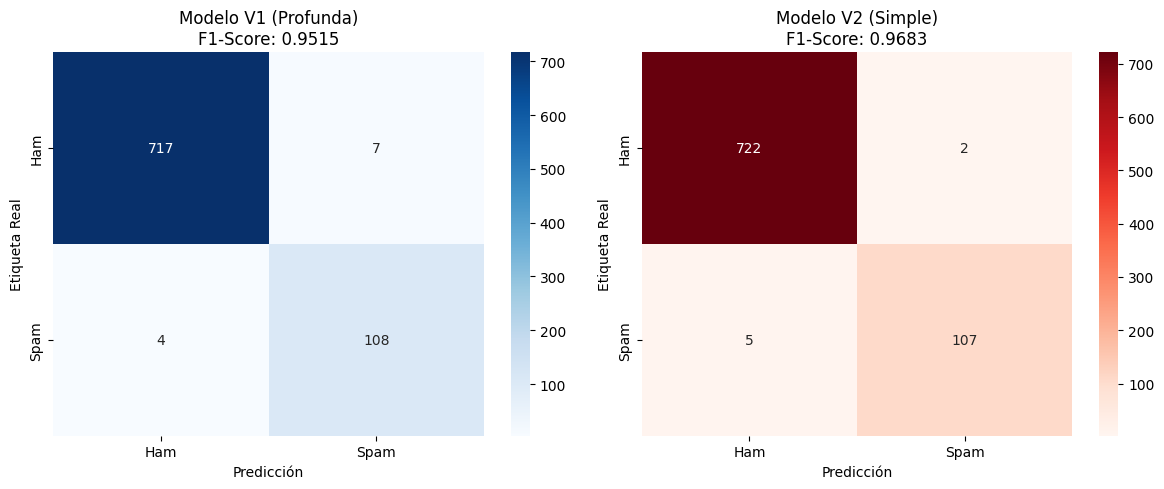

In [18]:
plt.figure(figsize=(12, 5))

# Matriz de confusión V1
plt.subplot(1, 2, 1)
cm_v1 = confusion_matrix(true_labels, pred_v1)
sns.heatmap(cm_v1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title(f'Modelo V1 (Profunda)\nF1-Score: {f1_v1:.4f}')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')

# Matriz de confusión V2
plt.subplot(1, 2, 2)
cm_v2 = confusion_matrix(true_labels, pred_v2)
sns.heatmap(cm_v2, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title(f'Modelo V2 (Simple)\nF1-Score: {f1_v2:.4f}')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')

plt.tight_layout()
plt.show()

En estas matrices de confusion se apoyan los resultados en los cuales denota como ambas arquitecturas tienen muy pocos errores en comparacion con su exito por lo que es una buena solucion para el problema de deteccion de spam y aun con mucho más espacio de mejora.

## (b) Evalue ambas arquitecturas previamente entrenadas, en 10 particiones aleatorias de entrenamiento y prueba, y reporte el F1-score promedio para ambas y su desviacion estandar. Comente los resultados.

## Entrenamiento con particiones diferentes

In [19]:
print("=" * 80)
print("                    PARTE 1B: VALIDACIÓN CON 10 PARTICIONES ALEATORIAS")
print("=" * 80)

import time
from sklearn.model_selection import train_test_split
import pandas as pd


def train_and_evaluate_on_split(model_class, X, y, test_size=0.3, random_state=42,
                                best_params=None, epochs=40, verbose=False):
    """
    Entrena y evalúa un modelo de red neuronal en una partición específica.

    Parámetros
    ----------
    model_class : class
        Clase del modelo de PyTorch a instanciar (ej: SpamClassifierV1, SpamClassifierV2).
        Debe heredar de nn.Module y tener una salida con activación sigmoid para clasificación binaria.

    X : torch.Tensor
        Tensor de características de entrada con shape [n_samples, n_features].
        Típicamente embeddings BERT con dimensionalidad de 768.

    y : torch.Tensor
        Tensor de etiquetas binarias con shape [n_samples].
        Valores: 0 (ham) o 1 (spam) como enteros.

    test_size : float, opcional, default=0.3
        Proporción del dataset a usar para prueba. El resto se usa para entrenamiento.
        Debe estar entre 0.0 y 1.0.

    random_state : int, opcional, default=42
        Semilla para la división aleatoria de datos. Permite reproducibilidad de resultados
        entre diferentes ejecuciones con los mismos parámetros.

    best_params : dict, opcional, default=None
        Diccionario con los hiperparámetros optimizados del modelo:
        - 'lr' : float - Learning rate para el optimizador Adam
        - 'wd' : float - Coeficiente de weight decay (regularización L2)
        Si es None, se deben proporcionar valores por defecto.

    epochs : int, opcional, default=40
        Número de épocas de entrenamiento. Controla cuántas pasadas completas
        sobre los datos de entrenamiento realizará el modelo.

    verbose : bool, opcional, default=False
        Si True, imprime información de pérdida cada 10 épocas durante el entrenamiento.
        Útil para monitoreo del progreso en entrenamientos largos.

    Retorna
    -------
    tuple[float, float]
        Una tupla con las métricas de evaluación en el conjunto de prueba:
        - f1 : float
            F1-score del modelo en el conjunto de prueba. Métrica balanceada que
            combina precisión y recall, especialmente útil para datos desbalanceados.
        - accuracy : float
            Exactitud (accuracy) del modelo en el conjunto de prueba.
            Proporción de predicciones correctas sobre el total de muestras.
    """
    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Crear datasets y loaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Crear y entrenar modelo
    model = model_class()
    model = model.to(device)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=best_params['lr'],
                           weight_decay=best_params['wd'])

    # Entrenamiento
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if verbose and (epoch + 1) % 10 == 0:
            print(f'    Época {epoch + 1}/{epochs}: Loss: {epoch_loss / len(train_loader):.4f}')

    # Evaluación
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)

            predictions = (outputs > 0.5).float().cpu().numpy().flatten()
            targets = batch_y.cpu().numpy().flatten()

            all_predictions.extend(predictions)
            all_targets.extend(targets)

    # Calcular métricas
    f1 = f1_score(all_targets, all_predictions)
    accuracy = np.mean(np.array(all_predictions) == np.array(all_targets))

    return f1, accuracy


# Configuración para las 10 particiones
n_splits = 10
test_size = 0.3  # 70% entrenamiento, 30% prueba
epochs_per_split = 40

# Almacenar resultados
results_v1 = {'f1_scores': [], 'accuracies': [], 'times': []}
results_v2 = {'f1_scores': [], 'accuracies': [], 'times': []}

print(f"Evaluando ambos modelos en {n_splits} particiones aleatorias...")
print(
    f"Configuración: {100 * (1 - test_size):.0f}% entrenamiento, {100 * test_size:.0f}% prueba, {epochs_per_split} épocas por partición")
print("-" * 80)

# Usar los mismos datos originales (embeddings_tensor, labels_tensor)
total_start_time = time.time()

for split in range(n_splits):
    print(f"\nPARTICIÓN {split + 1}/{n_splits}")

    # Usar diferentes seeds para cada partición
    random_seed = 42 + split * 10

    # Evaluar Modelo V1
    print("  Entrenando Modelo V1 (Red Profunda)...")
    start_time = time.time()
    f1_v1, acc_v1 = train_and_evaluate_on_split(
        SpamClassifierV1, embeddings_tensor, labels_tensor,
        test_size=test_size, random_state=random_seed,
        best_params=best_params_v1, epochs=epochs_per_split,
        verbose=False
    )
    time_v1 = time.time() - start_time

    results_v1['f1_scores'].append(f1_v1)
    results_v1['accuracies'].append(acc_v1)
    results_v1['times'].append(time_v1)

    # Evaluar Modelo V2
    print("  Entrenando Modelo V2 (Red Simple)...")
    start_time = time.time()
    f1_v2, acc_v2 = train_and_evaluate_on_split(
        SpamClassifierV2, embeddings_tensor, labels_tensor,
        test_size=test_size, random_state=random_seed,
        best_params=best_params_v2, epochs=epochs_per_split,
        verbose=False
    )
    time_v2 = time.time() - start_time

    results_v2['f1_scores'].append(f1_v2)
    results_v2['accuracies'].append(acc_v2)
    results_v2['times'].append(time_v2)

    # Mostrar resultados de esta partición
    print(f"  Resultados Partición {split + 1}:")
    print(f"    V1: F1={f1_v1:.4f}, Acc={acc_v1:.4f}, Tiempo={time_v1:.1f}s")
    print(f"    V2: F1={f1_v2:.4f}, Acc={acc_v2:.4f}, Tiempo={time_v2:.1f}s")

total_time = time.time() - total_start_time
print(f"\nEvaluación completada en {total_time:.1f} segundos")

                    PARTE 1B: VALIDACIÓN CON 10 PARTICIONES ALEATORIAS
Evaluando ambos modelos en 10 particiones aleatorias...
Configuración: 70% entrenamiento, 30% prueba, 40 épocas por partición
--------------------------------------------------------------------------------

PARTICIÓN 1/10
  Entrenando Modelo V1 (Red Profunda)...
  Entrenando Modelo V2 (Red Simple)...
  Resultados Partición 1:
    V1: F1=0.9638, Acc=0.9904, Tiempo=12.3s
    V2: F1=0.9607, Acc=0.9898, Tiempo=15.0s

PARTICIÓN 2/10
  Entrenando Modelo V1 (Red Profunda)...
  Entrenando Modelo V2 (Red Simple)...
  Resultados Partición 2:
    V1: F1=0.9638, Acc=0.9904, Tiempo=12.4s
    V2: F1=0.9513, Acc=0.9874, Tiempo=10.3s

PARTICIÓN 3/10
  Entrenando Modelo V1 (Red Profunda)...
  Entrenando Modelo V2 (Red Simple)...
  Resultados Partición 3:
    V1: F1=0.9641, Acc=0.9904, Tiempo=12.2s
    V2: F1=0.9558, Acc=0.9880, Tiempo=10.4s

PARTICIÓN 4/10
  Entrenando Modelo V1 (Red Profunda)...
  Entrenando Modelo V2 (Red Simple)

Para esta seccion del entrenamiento con particiones se generó la funcion `train_and_evaluate_on_split` la cual recibe el modelo, la division de un 70/30% para el entrenamiento y pruebas, los epochs y si se genera output verbose. Esta funcion contiene logica para partir el dataset con estratificacion para mantener ambas clases y con el uso de semillas para poder repetir los resultados en multiples corridas. No se utiliza el conjunto de validacion, ya que en este nos vamos a fijar en nada más el rendimiento del modelo y utilizar el esquema original no es necesario, ya que sería más costoso y esto es más para comparacion y referencia.

Esta seccion utiliza la misma logica anterior la cual se crean los TensorDataset, se carga el modelo al GPU, se alista el BCELoss y el optimizador Adam, asi como el mismo proceso de entrenamiento con el paso de `zero_grad`, model, criterion, loss.backward y optimizer.step. La unica diferencia es que en este se corren todos los epochs y no hay early stopping.

Finalmente, se almacenan las metricas de F1 Score, accuracy y tiempo de entrenamiento para cada una, esto con el fin de realizar un analisis comparativo más adelante.

Se ejecutan el entrenamiento por arquitectura para las diez particiones necesarias y se van guardando las metricas de cada una.

## Resultados del entrenamiento con particiones

In [20]:
print("\n" + "=" * 60)
print("                 ESTADÍSTICAS DE LAS 10 PARTICIONES")
print("=" * 60)

# Convertir a arrays numpy para facilitar cálculos
f1_scores_v1 = np.array(results_v1['f1_scores'])
f1_scores_v2 = np.array(results_v2['f1_scores'])
accuracies_v1 = np.array(results_v1['accuracies'])
accuracies_v2 = np.array(results_v2['accuracies'])

# Calcular estadísticas
stats_v1 = {
    'f1_mean': np.mean(f1_scores_v1),
    'f1_std': np.std(f1_scores_v1),
    'f1_min': np.min(f1_scores_v1),
    'f1_max': np.max(f1_scores_v1),
    'acc_mean': np.mean(accuracies_v1),
    'acc_std': np.std(accuracies_v1),
    'time_mean': np.mean(results_v1['times'])
}

stats_v2 = {
    'f1_mean': np.mean(f1_scores_v2),
    'f1_std': np.std(f1_scores_v2),
    'f1_min': np.min(f1_scores_v2),
    'f1_max': np.max(f1_scores_v2),
    'acc_mean': np.mean(accuracies_v2),
    'acc_std': np.std(accuracies_v2),
    'time_mean': np.mean(results_v2['times'])
}

# Mostrar resultados en tabla
print(f"\n{'Métrica':<20} {'Modelo V1':<15} {'Modelo V2':<15} {'Diferencia':<12}")
print("-" * 65)
print(
    f"{'F1-Score (μ ± σ)':<20} {stats_v1['f1_mean']:.4f} ± {stats_v1['f1_std']:.4f}  {stats_v2['f1_mean']:.4f} ± {stats_v2['f1_std']:.4f}  {abs(stats_v1['f1_mean'] - stats_v2['f1_mean']):.4f}")
print(
    f"{'F1-Score (min/max)':<20} {stats_v1['f1_min']:.4f} / {stats_v1['f1_max']:.4f}  {stats_v2['f1_min']:.4f} / {stats_v2['f1_max']:.4f}  -")
print(
    f"{'Accuracy (μ ± σ)':<20} {stats_v1['acc_mean']:.4f} ± {stats_v1['acc_std']:.4f}  {stats_v2['acc_mean']:.4f} ± {stats_v2['acc_std']:.4f}  {abs(stats_v1['acc_mean'] - stats_v2['acc_mean']):.4f}")
print(
    f"{'Tiempo promedio':<20} {stats_v1['time_mean']:.1f}s        {stats_v2['time_mean']:.1f}s        {abs(stats_v1['time_mean'] - stats_v2['time_mean']):.1f}s")

# Crear DataFrame para mejor visualización
results_df = pd.DataFrame({
    'Partición': range(1, n_splits + 1),
    'V1_F1': f1_scores_v1,
    'V2_F1': f1_scores_v2,
    'V1_Acc': accuracies_v1,
    'V2_Acc': accuracies_v2,
    'Diferencia_F1': f1_scores_v1 - f1_scores_v2
})

print(f"\nDETALLE POR PARTICIÓN:")
print(results_df.round(4))


                 ESTADÍSTICAS DE LAS 10 PARTICIONES

Métrica              Modelo V1       Modelo V2       Diferencia  
-----------------------------------------------------------------
F1-Score (μ ± σ)     0.9665 ± 0.0066  0.9595 ± 0.0091  0.0070
F1-Score (min/max)   0.9524 / 0.9772  0.9507 / 0.9772  -
Accuracy (μ ± σ)     0.9911 ± 0.0019  0.9892 ± 0.0025  0.0019
Tiempo promedio      12.3s        10.8s        1.4s

DETALLE POR PARTICIÓN:
   Partición   V1_F1   V2_F1  V1_Acc  V2_Acc  Diferencia_F1
0          1  0.9638  0.9607  0.9904  0.9898         0.0031
1          2  0.9638  0.9513  0.9904  0.9874         0.0125
2          3  0.9641  0.9558  0.9904  0.9880         0.0084
3          4  0.9772  0.9772  0.9940  0.9940         0.0000
4          5  0.9524  0.9542  0.9868  0.9874        -0.0019
5          6  0.9633  0.9507  0.9904  0.9868         0.0126
6          7  0.9712  0.9526  0.9922  0.9868         0.0186
7          8  0.9748  0.9748  0.9934  0.9934         0.0000
8          9  0.9

Como se observan de los resultados mostrados por la celda anterior sobre las corridas de las diferentes particiones en ambas arquitecturas se muestran distintos puntos.

El F1 Score en la arquitectura V1 sigue siendo superior al llegar a más de 0,96 en promedio y tener valores consistentes y muy similares, su accuracy tiene una diferencia menor en comparacion con la parte V2, además de individualmente presentar una mejora con los resultados iniciales. Al ver también los maximos y minimos la arquitectura V2 tiene un valor más bajo en comparacion y la arquitectura V1 siempre es más estable nunca bajando de 0,95.

En cuanto a la desviacion estandar del F1 Score se muestra que la arquitectura V1 es mucho más estable y la V2 es casi dos veces más dispersa, demostrando que la arquitectura V1 es más estable.

En el accuracy podemos ver en su desviacion estandar y resultados por particion, se puede ver como los resultados son muy similares y no existe una diferencia destacable entre las dos, ambas presentan valores estables y su desviacion indica que los resultados no estaban muy dispersos, asimismo sus resultados de accuracy son de más de 97% y no hay cambios drasticos entre corridas ni entre arquitecturas.

En cuanto al entrenamiento V2 es más rapida por ser un poco más simple, pero tiene un costo de ser más inestable y tener un poco de peores resultados, V1 sigue demostrando ser inclusive mejor que los resultados iniciales y los "peores" casos son de igual manera buenos por lo que es un buen candidato para la tarea y tiene una mejor capacidad de representacion.

/tmp/ipython-input-1927754316.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(box_data, labels=box_labels, patch_artist=True)


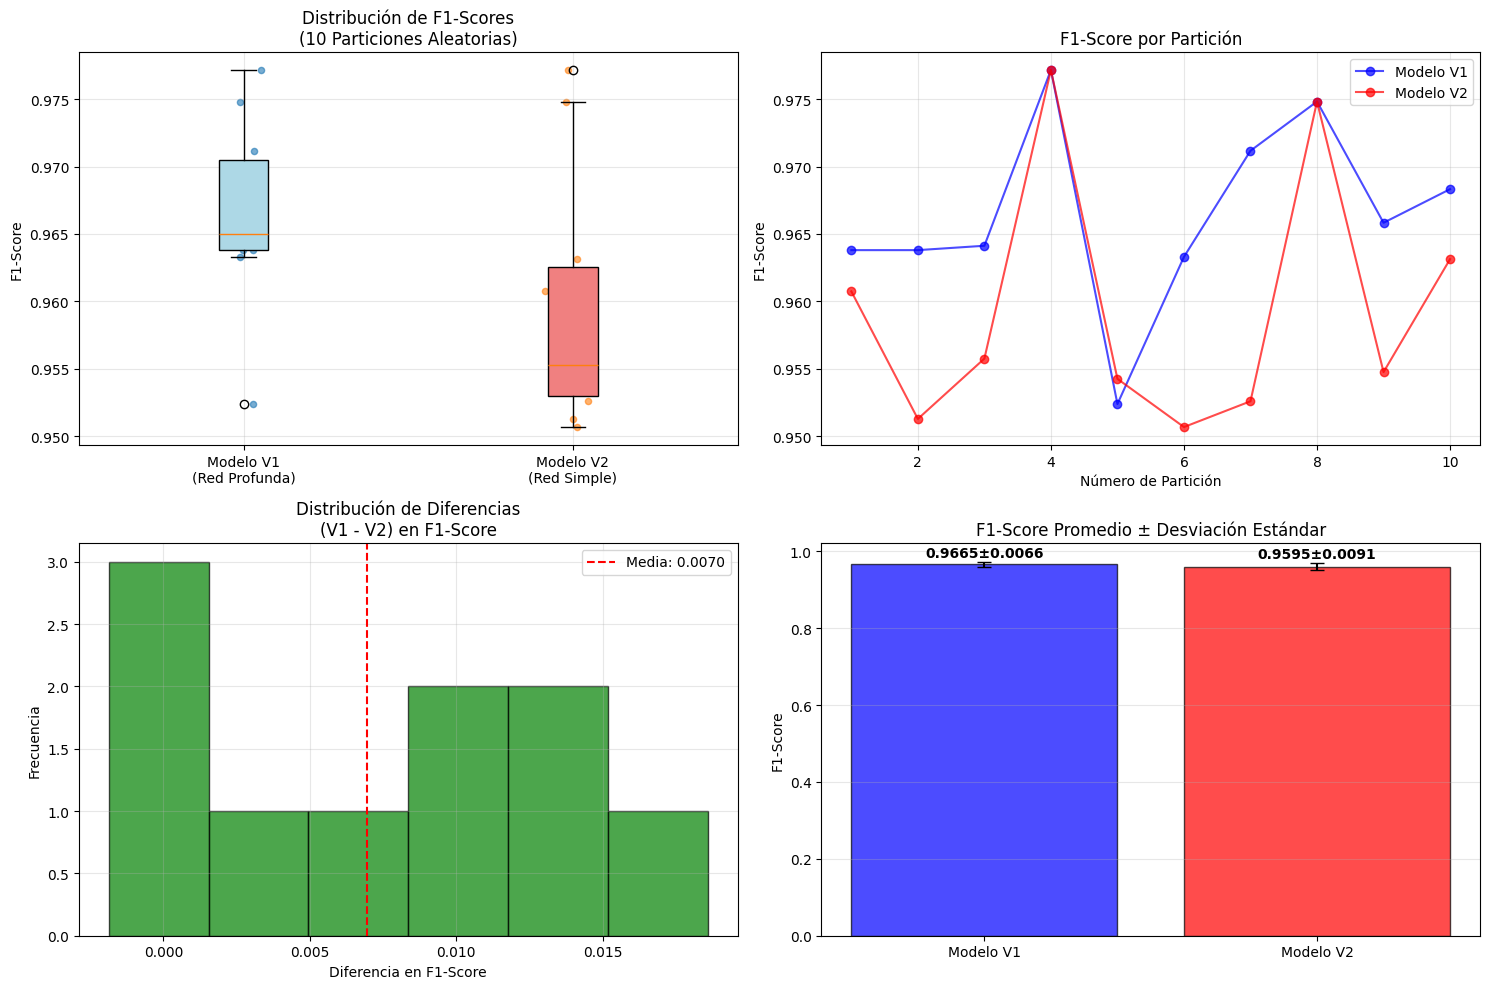

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Boxplot de F1-Scores
ax1 = axes[0, 0]
box_data = [f1_scores_v1, f1_scores_v2]
box_labels = ['Modelo V1\n(Red Profunda)', 'Modelo V2\n(Red Simple)']
bp = ax1.boxplot(box_data, labels=box_labels, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
ax1.set_title('Distribución de F1-Scores\n(10 Particiones Aleatorias)')
ax1.set_ylabel('F1-Score')
ax1.grid(True, alpha=0.3)

# Agregar puntos individuales
for i, data in enumerate(box_data, 1):
    y = data
    x = np.random.normal(i, 0.04, size=len(y))
    ax1.scatter(x, y, alpha=0.6, s=20)

# 2. F1-Scores por partición
ax2 = axes[0, 1]
partitions = range(1, n_splits + 1)
ax2.plot(partitions, f1_scores_v1, 'o-', label='Modelo V1', color='blue', alpha=0.7)
ax2.plot(partitions, f1_scores_v2, 'o-', label='Modelo V2', color='red', alpha=0.7)
ax2.set_title('F1-Score por Partición')
ax2.set_xlabel('Número de Partición')
ax2.set_ylabel('F1-Score')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Histograma de diferencias
ax3 = axes[1, 0]
differences = f1_scores_v1 - f1_scores_v2
ax3.hist(differences, bins=6, alpha=0.7, color='green', edgecolor='black')
ax3.axvline(np.mean(differences), color='red', linestyle='--',
            label=f'Media: {np.mean(differences):.4f}')
ax3.set_title('Distribución de Diferencias\n(V1 - V2) en F1-Score')
ax3.set_xlabel('Diferencia en F1-Score')
ax3.set_ylabel('Frecuencia')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Comparación de medias con intervalos de confianza
ax4 = axes[1, 1]
models = ['Modelo V1', 'Modelo V2']
means = [stats_v1['f1_mean'], stats_v2['f1_mean']]
stds = [stats_v1['f1_std'], stats_v2['f1_std']]
colors = ['blue', 'red']

bars = ax4.bar(models, means, yerr=stds, capsize=5,
               color=colors, alpha=0.7, edgecolor='black')
ax4.set_title('F1-Score Promedio ± Desviación Estándar')
ax4.set_ylabel('F1-Score')
ax4.grid(True, alpha=0.3, axis='y')

# Agregar valores en las barras
for bar, mean, std in zip(bars, means, stds):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width() / 2., height + std + 0.005,
             f'{mean:.4f}±{std:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

En estas gráficas se pueden visualizar mejor los resultados explicados anteriormente, se muestra la distribucion de F1 Score, por particion, promedio y desviacion estandar del mismo. Como se observó en los resultados en las tablas de las celdas anteriores la arquitectura V1 es superior marginalmente, la V2 tiene buenos resultados, pero es más dispersa, menos estable y con resultados un poco menores.

# 2. (20 puntos) Escoja al menos 2 modelos grandes del lenguaje, y uselos por medio del API de huggingface para hacer la clasificacion de los mensajes del dataset SMS_dataset, usando al menos una de las particiones de prueba anteriores. Reporte el prompt usado. Reporte el F1-score promedio para ambas y su desviacion estandar. Comente los resultados.

In [22]:
%pip install transformers accelerate bitsandbytes --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 13.2 MB/s eta 0:00:00


In [23]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

## Generacion de Prompt

In [67]:
def create_spam_classification_prompt(message):
    """
    Crea un prompt estructurado para clasificación de spam usando el conocimiento del dominio.

    Parámetros:
    -----------
    message : str
        Mensaje SMS a clasificar

    Retorna:
    --------
    str : Prompt formateado para el LLM
    """
    prompt = f"""Task: Classify the following SMS message as either "spam" or "ham" (legitimate).

Guidelines:
- SPAM indicators: promotional content, prizes, urgent calls to action, suspicious links, money requests, lottery/contests
- HAM indicators: personal conversations, legitimate business communications, informational messages

SMS Message: "{message}"

Please in your output only answer either the word "spam" or "ham" based on your prediction on the SMS Message, do not give descriptions or any explanation.

Classification: """

    return prompt


def extract_classification_from_response(response):
    """
    Extrae la clasificación de la respuesta del LLM.

    Parámetros:
    -----------
    response : str
        Respuesta completa del modelo

    Retorna:
    --------
    str : 'spam' o 'ham'
    """
    response_clean = response.lower().strip()

    # Buscar patrones de clasificación
    if 'spam' in response_clean and 'ham' not in response_clean:
        return 'spam'
    elif 'ham' in response_clean and 'spam' not in response_clean:
        return 'ham'
    elif response_clean.startswith('spam'):
        return 'spam'
    elif response_clean.startswith('ham'):
        return 'ham'
    else:
        # Se usa ham por defecto en caso de no clasificar
        print(f"\nRespuesta no clasificable: {response_clean}")
        return 'ham'


# Mostrar ejemplo del prompt utilizado
sample_msg = "URGENT! You've won £1000! Call 09061701461 to claim now!"
print("PROMPT UTILIZADO EN LA EVALUACIÓN:")
print("=" * 50)
print(create_spam_classification_prompt(sample_msg))
print("=" * 50)

PROMPT UTILIZADO EN LA EVALUACIÓN:
Task: Classify the following SMS message as either "spam" or "ham" (legitimate).

Guidelines:
- SPAM indicators: promotional content, prizes, urgent calls to action, suspicious links, money requests, lottery/contests
- HAM indicators: personal conversations, legitimate business communications, informational messages

SMS Message: "URGENT! You've won £1000! Call 09061701461 to claim now!"

Please in your output only answer either the word "spam" or "ham" based on your prediction on the SMS Message, do not give descriptions or any explanation.

Classification: 


Esta funcion genera el prompt y el mensaje de arriba es una muestra de como se observaria. Se intentaron utilizar distintos prompts y este demostro ser el mejor para las pruebas, ya que se determinó que es necesario que el prompt sea conciso para modelos pequeños como los que utilizamos, pero también con el contexto de que significa spam o ham, además de darle la direccion explicita de que solo genere como salida la clasificacion, algo que es difícil, ya que los LLM pueden generar respuestas largas o divagar en sus resultados.

Además, contiene la funcion de clasificacion que permite determinar si dentro del resultado se contiene solo la palabra ham o spam, si no se encuentra se imprime el resultado de una salida anomala y se clasifica como ham por defecto.

## Logica de los Modelos y Funciones de Clasificacion

In [68]:
class LLMSpamClassifier:
    """
    Clasificador de spam usando modelos de lenguaje.
    """

    def __init__(self, model_name, use_quantization=True):
        self.model_name = model_name
        self.use_quantization = use_quantization
        self.tokenizer = None
        self.model = None
        self.device = device

    def load_model(self):
        """Carga el modelo y tokenizer."""
        try:
            print(f"Cargando {self.model_name}...")

            # Cargar tokenizer
            self.tokenizer = AutoTokenizer.from_pretrained(
                self.model_name,
                trust_remote_code=True
            )
            if self.tokenizer.pad_token is None:
                self.tokenizer.pad_token = self.tokenizer.eos_token

            # Cargar modelo
            self.model = AutoModelForCausalLM.from_pretrained(
                self.model_name,
                quantization_config=None,
                device_map="auto" if torch.cuda.is_available() else None,
                torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
                trust_remote_code=True
            )

            print(f"{self.model_name} cargado exitosamente")
            return True

        except Exception as e:
            print(f"Error cargando {self.model_name}: {str(e)}")
            return False

    def classify_single_message(self, message, max_length=400):
        """
        Clasifica un mensaje individual.

        Parámetros:
        -----------
        message : str
            Mensaje a clasificar
        max_length : int
            Longitud máxima del prompt

        Retorna:
        --------
        str : 'spam' o 'ham'
        """
        if self.model is None:
            raise ValueError("Modelo no cargado. Ejecuta load_model() primero.")

        prompt = create_spam_classification_prompt(message)

        # Tokenizar entrada
        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            max_length=max_length,
            truncation=True,
            padding=True
        )

        # Mover tensores al dispositivo del modelo
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}

        # Generar respuesta
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=5,
                do_sample=False,
                temperature=0.1,
                pad_token_id=self.tokenizer.eos_token_id,
                eos_token_id=self.tokenizer.eos_token_id
            )

        # Decodificar solo la parte nueva de la respuesta
        response = self.tokenizer.decode(
            outputs[0][inputs['input_ids'].shape[1]:],
            skip_special_tokens=True
        )

        return extract_classification_from_response(response)

    def classify_messages_batch(self, messages, batch_size=4, show_progress=True):
        """
        Clasifica un lote de mensajes.

        Parámetros:
        -----------
        messages : list
            Lista de mensajes a clasificar
        batch_size : int
            Tamaño del lote (reducido para LLMs)
        show_progress : bool
            Mostrar barra de progreso

        Retorna:
        --------
        list : Lista de clasificaciones
        """
        predictions = []
        total_unclassifiable = 0
        iterator = tqdm(range(0, len(messages), batch_size),
                        desc=f"Clasificando con {self.model_name.split('/')[-1]}") if show_progress else range(0,
                                                                                                               len(messages),
                                                                                                               batch_size)

        for i in iterator:
            batch = messages[i:i + batch_size]

            for message in batch:
                try:
                    pred = self.classify_single_message(message)
                    predictions.append(pred)
                except Exception as e:
                    print(f"\nError en mensaje: {str(e)}")
                    predictions.append('ham')  # Clasificación segura por defecto
                    total_unclassifiable += 1

            # Pausa breve para gestión de memoria
            time.sleep(0.2)

        if total_unclassifiable > 0:
            print(f"\n{total_unclassifiable} mensajes no pudieron ser clasificados correctamente")

        return predictions

La clase `LLMSpamClassifier` contiene la logica para cargar el modelo y clasificar los mensajes en lotes.

En esta clase se carga el modelo por medio de la biblioteca `transformers` y también está encargada de realizar la clasificacion de los mensajes por medio de la tokenizacion de las entradas, generar la respuesta con una limitacion de 5 tokens para poder solamente recibir el resultado de `ham` o `spam`. Estas funciones también tienen la capacidad de detectar errores en las salidas y guardar el número de mensajes que no se pudieron clasificar en caso de excepciones.

## Configuracion de Modelos de Hugging Face

In [73]:
llm_models_config = {
    "Llama-3-1B": {
        "model_name": "meta-llama/Llama-3.2-1B-Instruct",
        "use_quantization": False,
        "description": "Llama-3.2-1B-Instruct"
    },
    "Qwen-2-5-1.5B": {
        "model_name": "Qwen/Qwen2.5-1.5B-Instruct",
        "use_quantization": False,
        "description": "wen2.5-1.5B-Instruct"
    },
}

print("MODELOS LLM CONFIGURADOS PARA EVALUACIÓN:")
print("-" * 50)
for name, config in llm_models_config.items():
    print(f"• {name}: {config['model_name']}")
    print(f"  └─ {config['description']}")
print("-" * 50)

MODELOS LLM CONFIGURADOS PARA EVALUACIÓN:
--------------------------------------------------
• Llama-3-1B: meta-llama/Llama-3.2-1B-Instruct
  └─ Llama-3.2-1B-Instruct
• Qwen-2-5-1.5B: Qwen/Qwen2.5-1.5B-Instruct
  └─ wen2.5-1.5B-Instruct
--------------------------------------------------


Se escogieron estos dos LLM dentro de Hugging Face debido a que tienen un numero pequeño de parametros que ayuda a que el modelo tenga un tamaño pequeño y sea rapido para las pruebas. Además de eso este trabajo se desarrolló en Google Colab con una gráfica de T4, por lo que escoger modelos con muy alto nivel de parametros no era factible.

## Generación de Particiones y Entrenamiento

In [74]:
def get_test_partition(split_index, max_test_samples=100):
    """
    Obtiene la misma partición de test usada en las evaluaciones de RN.

    Parámetros:
    -----------
    split_index : int
        Índice de la partición (0-9)
    max_test_samples : int
        Máximo de muestras para eficiencia con LLMs

    Retorna:
    --------
    tuple : (test_messages, test_labels_str, test_labels_numeric)
    """
    # Usar la misma lógica que train_and_evaluate_on_split
    random_seed = 42 + split_index * 10
    test_size = 0.3

    # Dividir datos con la misma estrategia
    original_indices = list(range(len(sms_df)))
    train_idx, test_idx = train_test_split(
        original_indices,
        test_size=test_size,
        random_state=random_seed,
        stratify=labels_tensor.numpy()
    )

    # Extraer mensajes y etiquetas del conjunto de prueba
    test_messages = [sms_df.iloc[idx]['message'] for idx in test_idx]
    test_labels_str = [sms_df.iloc[idx]['label'] for idx in test_idx]
    test_labels_numeric = [1 if label == 'spam' else 0 for label in test_labels_str]

    # Muestreo estratificado para eficiencia con LLMs
    if len(test_messages) > max_test_samples:
        # Mantener proporción de clases en la muestra
        stratified_sample_idx, _ = train_test_split(
            range(len(test_messages)),
            train_size=max_test_samples,
            random_state=42,
            stratify=test_labels_numeric
        )

        test_messages = [test_messages[i] for i in stratified_sample_idx]
        test_labels_str = [test_labels_str[i] for i in stratified_sample_idx]
        test_labels_numeric = [test_labels_numeric[i] for i in stratified_sample_idx]

    return test_messages, test_labels_str, test_labels_numeric


# Probar la función con una partición de ejemplo
test_msgs, test_lbls_str, test_lbls_num = get_test_partition(0)
print(f"Partición de prueba extraída:")
print(f"   • Total mensajes: {len(test_msgs)}")
print(f"   • Ham: {test_lbls_str.count('ham')} ({test_lbls_str.count('ham') / len(test_msgs) * 100:.1f}%)")
print(f"   • Spam: {test_lbls_str.count('spam')} ({test_lbls_str.count('spam') / len(test_msgs) * 100:.1f}%)")

print(f"\nEjemplos de mensajes:")
for i in range(min(3, len(test_msgs))):
    print(f"   [{test_lbls_str[i]}] {test_msgs[i][:70]}...")

Partición de prueba extraída:
   • Total mensajes: 100
   • Ham: 87 (87.0%)
   • Spam: 13 (13.0%)

Ejemplos de mensajes:
   [ham] Hi :)finally i completed the course:)...
   [ham] 2 and half years i missed your friendship:-)...
   [spam] Mobile Club: Choose any of the top quality items for your mobile. 7cfc...


La funcion `get_test_partition` permite generar una particion de prueba para poder usada para la evaluacion. Esta genera un total de 100 mensajes con una distribucion variada de clases, en los resultados se puede ver como se obtiene en su mayoria más mensajes de "ham" debido a que este dataset es desbalanceado. Finalmente, este también separa y extrae los mensajes, su etiqueta y la transformacion de su etiqueta a numeros para su uso posterior en las pruebas.

In [75]:
def evaluate_llm_multiple_partitions(classifier, n_splits=5, max_samples_per_partition=100):
    """
    Evalúa un clasificador LLM usando el mismo esquema de particiones que las redes neuronales.

    Parámetros:
    -----------
    classifier : LLMSpamClassifier
        Clasificador LLM inicializado y cargado
    n_splits : int
        Número de particiones (usar menos que RN por eficiencia)
    max_samples_per_partition : int
        Máximo de mensajes por partición

    Retorna:
    --------
    dict : Resultados con F1-scores y accuracies
    """
    f1_scores = []
    accuracies = []

    print(f"\nEvaluando {classifier.model_name.split('/')[-1]} en {n_splits} particiones")
    print(f"Usando máximo {max_samples_per_partition} mensajes por partición")

    for split in range(n_splits):
        print(f"\n--- Partición {split + 1}/{n_splits} ---")

        # Obtener datos de prueba para esta partición
        test_messages, test_labels_str, test_labels_numeric = get_test_partition(
            split, max_samples_per_partition
        )

        print(f"Evaluando {len(test_messages)} mensajes...")

        try:
            # Clasificar usando el LLM
            predictions_str = classifier.classify_messages_batch(test_messages, batch_size=3)

            # Convertir predicciones a formato numérico
            predictions_numeric = [1 if pred == 'spam' else 0 for pred in predictions_str]

            # Calcular métricas
            f1 = f1_score(test_labels_numeric, predictions_numeric, zero_division=0.0)
            accuracy = np.mean(np.array(predictions_numeric) == np.array(test_labels_numeric))

            f1_scores.append(f1)
            accuracies.append(accuracy)

            print(f"Resultados: F1={f1:.4f}, Accuracy={accuracy:.4f}")

            # Mostrar ejemplos de clasificación
            print("Ejemplos de clasificación:")
            correct_count = 0
            for i in range(min(4, len(predictions_str))):
                is_correct = predictions_str[i] == test_labels_str[i]
                if is_correct:
                    correct_count += 1
                status = "✅" if is_correct else "❌"
                print(
                    f"   {status} Real: {test_labels_str[i]:4} | Pred: {predictions_str[i]:4} | {test_messages[i][:55]}...")

            print(f"   Precisión en ejemplos: {correct_count}/{min(4, len(predictions_str))}")

        except Exception as e:
            print(f"Error en partición {split + 1}: {str(e)}")
            f1_scores.append(0.0)
            accuracies.append(0.5)  # Random baseline

    # Calcular estadísticas finales
    stats = {
        'f1_scores': f1_scores,
        'accuracies': accuracies,
        'f1_mean': np.mean(f1_scores),
        'f1_std': np.std(f1_scores),
        'acc_mean': np.mean(accuracies),
        'acc_std': np.std(accuracies)
    }

    return stats

La funcion `evaluate_llm_multiple_partitions` esta encargada de evaluar el dataset con cada particion, en ella se va a generar la particion, se clasifica usando el LLM por medio de lotes de mensajes y se convierte la prediccion a un valor numerico, en el cual se va a generar el F1 Score y el accuracy, asi como algunos ejemplos extraidos como muestra de la clasificacion en cada particion. Se guardan todas las metricas y sus momentos estadisticos para su posterior uso.

In [76]:
print("=" * 80)
print("INICIANDO EVALUACIÓN DE MODELOS LLM")
print("=" * 80)

# Configuración de la evaluación
n_evaluation_splits = 10
llm_results = {}

# Evaluar cada modelo LLM
for model_name, config in llm_models_config.items():
    print(f"\n{'=' * 60}")
    print(f"EVALUANDO: {model_name}")
    print(f"Modelo: {config['model_name']}")
    print(f"Descripción: {config['description']}")
    print(f"{'=' * 60}")

    # Inicializar clasificador
    classifier = LLMSpamClassifier(
        config["model_name"],
        config["use_quantization"]
    )

    # Cargar modelo
    model_loaded = classifier.load_model()

    if model_loaded:
        try:
            # Evaluar en múltiples particiones
            results = evaluate_llm_multiple_partitions(
                classifier,
                n_evaluation_splits
            )

            llm_results[model_name] = results

            print(f"\nRESULTADOS FINALES - {model_name}:")
            print(f"   F1-Score: {results['f1_mean']:.4f} ± {results['f1_std']:.4f}")
            print(f"   Accuracy: {results['acc_mean']:.4f} ± {results['acc_std']:.4f}")

        except Exception as e:
            print(f"Error durante evaluación: {str(e)}")
            # Resultados por defecto en caso de error
            llm_results[model_name] = {
                'f1_scores': [0.0] * n_evaluation_splits,
                'accuracies': [0.5] * n_evaluation_splits,
                'f1_mean': 0.0,
                'f1_std': 0.0,
                'acc_mean': 0.5,
                'acc_std': 0.0
            }

        # Limpieza de memoria GPU
        try:
            del classifier.model
            del classifier.tokenizer
            torch.cuda.empty_cache()
            print("Memoria GPU limpiada")
        except:
            pass

    else:
        print(f"No se pudo cargar el modelo {model_name}")
        # Resultados por defecto
        llm_results[model_name] = {
            'f1_scores': [0.0] * n_evaluation_splits,
            'accuracies': [0.5] * n_evaluation_splits,
            'f1_mean': 0.0,
            'f1_std': 0.0,
            'acc_mean': 0.5,
            'acc_std': 0.0
        }

INICIANDO EVALUACIÓN DE MODELOS LLM

EVALUANDO: Llama-3-1B
Modelo: meta-llama/Llama-3.2-1B-Instruct
Descripción: Llama-3.2-1B-Instruct
Cargando meta-llama/Llama-3.2-1B-Instruct...
meta-llama/Llama-3.2-1B-Instruct cargado exitosamente

Evaluando Llama-3.2-1B-Instruct en 10 particiones
Usando máximo 100 mensajes por partición

--- Partición 1/10 ---
Evaluando 100 mensajes...


Clasificando con Llama-3.2-1B-Instruct:   0%|          | 0/34 [00:00<?, ?it/s]


Respuesta no clasificable: 7cfca1a


Clasificando con Llama-3.2-1B-Instruct: 100%|██████████| 34/34 [00:14<00:00,  2.41it/s]


Resultados: F1=0.3265, Accuracy=0.6700
Ejemplos de clasificación:
   ✅ Real: ham  | Pred: ham  | Hi :)finally i completed the course:)...
   ✅ Real: ham  | Pred: ham  | 2 and half years i missed your friendship:-)...
   ❌ Real: spam | Pred: ham  | Mobile Club: Choose any of the top quality items for yo...
   ✅ Real: ham  | Pred: ham  | Its worse if if uses half way then stops. Its better fo...
   Precisión en ejemplos: 3/4

--- Partición 2/10 ---
Evaluando 100 mensajes...


Clasificando con Llama-3.2-1B-Instruct: 100%|██████████| 34/34 [00:14<00:00,  2.31it/s]


Resultados: F1=0.2500, Accuracy=0.5200
Ejemplos de clasificación:
   ❌ Real: ham  | Pred: spam | Ok lar... Joking wif u oni......
   ❌ Real: ham  | Pred: spam | To day class is there are no class....
   ❌ Real: spam | Pred: ham  | Had your contract mobile 11 Mnths? Latest Motorola, Nok...
   ❌ Real: ham  | Pred: spam | G wants to know where the fuck you are...
   Precisión en ejemplos: 0/4

--- Partición 3/10 ---
Evaluando 100 mensajes...


Clasificando con Llama-3.2-1B-Instruct: 100%|██████████| 34/34 [00:14<00:00,  2.40it/s]


Resultados: F1=0.3448, Accuracy=0.6200
Ejemplos de clasificación:
   ❌ Real: ham  | Pred: spam | How i noe... She's in da car now... Later then c lar......
   ✅ Real: ham  | Pred: ham  | Solve d Case : A Man Was Found Murdered On  &lt;DECIMAL...
   ✅ Real: spam | Pred: spam | Congratulations YOU'VE Won. You're a Winner in our Augu...
   ❌ Real: ham  | Pred: spam | Anything......
   Precisión en ejemplos: 2/4

--- Partición 4/10 ---
Evaluando 100 mensajes...


Clasificando con Llama-3.2-1B-Instruct: 100%|██████████| 34/34 [00:13<00:00,  2.47it/s]


Resultados: F1=0.3265, Accuracy=0.6700
Ejemplos de clasificación:
   ✅ Real: ham  | Pred: ham  | And how you will do that, princess? :)...
   ✅ Real: ham  | Pred: ham  | Moji i love you more than words. Have a rich day...
   ✅ Real: spam | Pred: spam | Not heard from U4 a while. Call me now am here all nigh...
   ✅ Real: ham  | Pred: ham  | I'll meet you in the lobby...
   Precisión en ejemplos: 4/4

--- Partición 5/10 ---
Evaluando 100 mensajes...


Clasificando con Llama-3.2-1B-Instruct: 100%|██████████| 34/34 [00:14<00:00,  2.40it/s]


Resultados: F1=0.3793, Accuracy=0.6400
Ejemplos de clasificación:
   ❌ Real: ham  | Pred: spam | Go fool dont cheat others ok...
   ✅ Real: ham  | Pred: ham  | Nope. I just forgot. Will show next week...
   ❌ Real: spam | Pred: ham  | This is the 2nd attempt to contract U, you have won thi...
   ❌ Real: ham  | Pred: spam | I got a call from a landline number. . . I am asked to ...
   Precisión en ejemplos: 1/4

--- Partición 6/10 ---
Evaluando 100 mensajes...


Clasificando con Llama-3.2-1B-Instruct: 100%|██████████| 34/34 [00:13<00:00,  2.44it/s]


Resultados: F1=0.3913, Accuracy=0.7200
Ejemplos de clasificación:
   ✅ Real: ham  | Pred: ham  | Lol ... I really need to remember to eat when I'm drink...
   ❌ Real: ham  | Pred: spam | hi my darlin im on my way to London and we have just be...
   ✅ Real: spam | Pred: spam | 1000's of girls many local 2 u who r virgins 2 this & r...
   ✅ Real: ham  | Pred: ham  | No problem baby. Is this is a good time to talk? I call...
   Precisión en ejemplos: 3/4

--- Partición 7/10 ---
Evaluando 100 mensajes...


Clasificando con Llama-3.2-1B-Instruct: 100%|██████████| 34/34 [00:14<00:00,  2.42it/s]


Resultados: F1=0.2449, Accuracy=0.6300
Ejemplos de clasificación:
   ❌ Real: ham  | Pred: spam | Ugh my leg hurts. Musta overdid it on mon....
   ❌ Real: ham  | Pred: spam | I meant as an apology from me for texting you to get me...
   ❌ Real: spam | Pred: ham  | 85233 FREE>Ringtone!Reply REAL...
   ✅ Real: ham  | Pred: ham  | Me sef dey laugh you. Meanwhile how's my darling anjie!...
   Precisión en ejemplos: 1/4

--- Partición 8/10 ---
Evaluando 100 mensajes...


Clasificando con Llama-3.2-1B-Instruct: 100%|██████████| 34/34 [00:13<00:00,  2.46it/s]


Resultados: F1=0.3137, Accuracy=0.6500
Ejemplos de clasificación:
   ✅ Real: ham  | Pred: ham  | I don't know, same thing that's wrong everyso often, he...
   ✅ Real: ham  | Pred: ham  | Tomorrow i am not going to theatre. . . So i can come w...
   ✅ Real: spam | Pred: spam | Claim a 200 shopping spree, just call 08717895698 now! ...
   ❌ Real: ham  | Pred: spam | IM GONNA MISS U SO MUCH...
   Precisión en ejemplos: 3/4

--- Partición 9/10 ---
Evaluando 100 mensajes...


Clasificando con Llama-3.2-1B-Instruct: 100%|██████████| 34/34 [00:14<00:00,  2.36it/s]


Resultados: F1=0.3103, Accuracy=0.6000
Ejemplos de clasificación:
   ✅ Real: ham  | Pred: ham  | Be sure to check your yahoo email. We sent photos yeste...
   ✅ Real: ham  | Pred: ham  | Networking job is there....
   ✅ Real: spam | Pred: spam | Your 2004 account for 07XXXXXXXXX shows 786 unredeemed ...
   ✅ Real: ham  | Pred: ham  | Hasn't that been the pattern recently crap weekends?...
   Precisión en ejemplos: 4/4

--- Partición 10/10 ---
Evaluando 100 mensajes...


Clasificando con Llama-3.2-1B-Instruct: 100%|██████████| 34/34 [00:14<00:00,  2.41it/s]


Resultados: F1=0.3636, Accuracy=0.6500
Ejemplos de clasificación:
   ❌ Real: ham  | Pred: spam | I can't keep going through this. It was never my intent...
   ✅ Real: ham  | Pred: ham  | Or ü go buy wif him then i meet ü later can?...
   ❌ Real: spam | Pred: ham  | Camera - You are awarded a SiPix Digital Camera! call 0...
   ✅ Real: ham  | Pred: ham  | Still in the area of the restaurant. Ill try to come ba...
   Precisión en ejemplos: 2/4

RESULTADOS FINALES - Llama-3-1B:
   F1-Score: 0.3251 ± 0.0465
   Accuracy: 0.6370 ± 0.0498
Memoria GPU limpiada

EVALUANDO: Qwen-2-5-1.5B
Modelo: Qwen/Qwen2.5-1.5B-Instruct
Descripción: wen2.5-1.5B-Instruct
Cargando Qwen/Qwen2.5-1.5B-Instruct...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Qwen/Qwen2.5-1.5B-Instruct cargado exitosamente

Evaluando Qwen2.5-1.5B-Instruct en 10 particiones
Usando máximo 100 mensajes por partición

--- Partición 1/10 ---
Evaluando 100 mensajes...


Clasificando con Qwen2.5-1.5B-Instruct: 100%|██████████| 34/34 [00:27<00:00,  1.24it/s]


Resultados: F1=0.4706, Accuracy=0.7300
Ejemplos de clasificación:
   ✅ Real: ham  | Pred: ham  | Hi :)finally i completed the course:)...
   ✅ Real: ham  | Pred: ham  | 2 and half years i missed your friendship:-)...
   ✅ Real: spam | Pred: spam | Mobile Club: Choose any of the top quality items for yo...
   ✅ Real: ham  | Pred: ham  | Its worse if if uses half way then stops. Its better fo...
   Precisión en ejemplos: 4/4

--- Partición 2/10 ---
Evaluando 100 mensajes...


Clasificando con Qwen2.5-1.5B-Instruct: 100%|██████████| 34/34 [00:27<00:00,  1.24it/s]


Resultados: F1=0.4727, Accuracy=0.7100
Ejemplos de clasificación:
   ✅ Real: ham  | Pred: ham  | Ok lar... Joking wif u oni......
   ✅ Real: ham  | Pred: ham  | To day class is there are no class....
   ✅ Real: spam | Pred: spam | Had your contract mobile 11 Mnths? Latest Motorola, Nok...
   ❌ Real: ham  | Pred: spam | G wants to know where the fuck you are...
   Precisión en ejemplos: 3/4

--- Partición 3/10 ---
Evaluando 100 mensajes...


Clasificando con Qwen2.5-1.5B-Instruct: 100%|██████████| 34/34 [00:27<00:00,  1.23it/s]


Resultados: F1=0.4262, Accuracy=0.6500
Ejemplos de clasificación:
   ✅ Real: ham  | Pred: ham  | How i noe... She's in da car now... Later then c lar......
   ❌ Real: ham  | Pred: spam | Solve d Case : A Man Was Found Murdered On  &lt;DECIMAL...
   ✅ Real: spam | Pred: spam | Congratulations YOU'VE Won. You're a Winner in our Augu...
   ❌ Real: ham  | Pred: spam | Anything......
   Precisión en ejemplos: 2/4

--- Partición 4/10 ---
Evaluando 100 mensajes...


Clasificando con Qwen2.5-1.5B-Instruct: 100%|██████████| 34/34 [00:27<00:00,  1.24it/s]


Resultados: F1=0.4706, Accuracy=0.7300
Ejemplos de clasificación:
   ✅ Real: ham  | Pred: ham  | And how you will do that, princess? :)...
   ✅ Real: ham  | Pred: ham  | Moji i love you more than words. Have a rich day...
   ✅ Real: spam | Pred: spam | Not heard from U4 a while. Call me now am here all nigh...
   ✅ Real: ham  | Pred: ham  | I'll meet you in the lobby...
   Precisión en ejemplos: 4/4

--- Partición 5/10 ---
Evaluando 100 mensajes...


Clasificando con Qwen2.5-1.5B-Instruct: 100%|██████████| 34/34 [00:27<00:00,  1.25it/s]


Resultados: F1=0.4062, Accuracy=0.6200
Ejemplos de clasificación:
   ❌ Real: ham  | Pred: spam | Go fool dont cheat others ok...
   ✅ Real: ham  | Pred: ham  | Nope. I just forgot. Will show next week...
   ✅ Real: spam | Pred: spam | This is the 2nd attempt to contract U, you have won thi...
   ✅ Real: ham  | Pred: ham  | I got a call from a landline number. . . I am asked to ...
   Precisión en ejemplos: 3/4

--- Partición 6/10 ---
Evaluando 100 mensajes...


Clasificando con Qwen2.5-1.5B-Instruct: 100%|██████████| 34/34 [00:27<00:00,  1.24it/s]


Resultados: F1=0.4906, Accuracy=0.7300
Ejemplos de clasificación:
   ✅ Real: ham  | Pred: ham  | Lol ... I really need to remember to eat when I'm drink...
   ❌ Real: ham  | Pred: spam | hi my darlin im on my way to London and we have just be...
   ✅ Real: spam | Pred: spam | 1000's of girls many local 2 u who r virgins 2 this & r...
   ✅ Real: ham  | Pred: ham  | No problem baby. Is this is a good time to talk? I call...
   Precisión en ejemplos: 3/4

--- Partición 7/10 ---
Evaluando 100 mensajes...


Clasificando con Qwen2.5-1.5B-Instruct: 100%|██████████| 34/34 [00:27<00:00,  1.23it/s]


Resultados: F1=0.4583, Accuracy=0.7400
Ejemplos de clasificación:
   ✅ Real: ham  | Pred: ham  | Ugh my leg hurts. Musta overdid it on mon....
   ❌ Real: ham  | Pred: spam | I meant as an apology from me for texting you to get me...
   ✅ Real: spam | Pred: spam | 85233 FREE>Ringtone!Reply REAL...
   ❌ Real: ham  | Pred: spam | Me sef dey laugh you. Meanwhile how's my darling anjie!...
   Precisión en ejemplos: 2/4

--- Partición 8/10 ---
Evaluando 100 mensajes...


Clasificando con Qwen2.5-1.5B-Instruct: 100%|██████████| 34/34 [00:27<00:00,  1.25it/s]


Resultados: F1=0.4407, Accuracy=0.6700
Ejemplos de clasificación:
   ✅ Real: ham  | Pred: ham  | I don't know, same thing that's wrong everyso often, he...
   ❌ Real: ham  | Pred: spam | Tomorrow i am not going to theatre. . . So i can come w...
   ✅ Real: spam | Pred: spam | Claim a 200 shopping spree, just call 08717895698 now! ...
   ❌ Real: ham  | Pred: spam | IM GONNA MISS U SO MUCH...
   Precisión en ejemplos: 2/4

--- Partición 9/10 ---
Evaluando 100 mensajes...


Clasificando con Qwen2.5-1.5B-Instruct: 100%|██████████| 34/34 [00:27<00:00,  1.24it/s]


Resultados: F1=0.3492, Accuracy=0.5900
Ejemplos de clasificación:
   ✅ Real: ham  | Pred: ham  | Be sure to check your yahoo email. We sent photos yeste...
   ✅ Real: ham  | Pred: ham  | Networking job is there....
   ✅ Real: spam | Pred: spam | Your 2004 account for 07XXXXXXXXX shows 786 unredeemed ...
   ✅ Real: ham  | Pred: ham  | Hasn't that been the pattern recently crap weekends?...
   Precisión en ejemplos: 4/4

--- Partición 10/10 ---
Evaluando 100 mensajes...


Clasificando con Qwen2.5-1.5B-Instruct: 100%|██████████| 34/34 [00:32<00:00,  1.05it/s]

Resultados: F1=0.4483, Accuracy=0.6800
Ejemplos de clasificación:
   ❌ Real: ham  | Pred: spam | I can't keep going through this. It was never my intent...
   ❌ Real: ham  | Pred: spam | Or ü go buy wif him then i meet ü later can?...
   ✅ Real: spam | Pred: spam | Camera - You are awarded a SiPix Digital Camera! call 0...
   ✅ Real: ham  | Pred: ham  | Still in the area of the restaurant. Ill try to come ba...
   Precisión en ejemplos: 2/4

RESULTADOS FINALES - Qwen-2-5-1.5B:
   F1-Score: 0.4433 ± 0.0392
   Accuracy: 0.6850 ± 0.0494
Memoria GPU limpiada


En los resultados anteriores se puede observar la evaluacion de 100 mensajes por cada particion, se muestra el F1 Score y Accuracy por cada uno, además si existiera algún error o una salida anomala deberia mostrarse también en la salida.

Los resultados muestran que las particiones no cambian de gran manera las metricas. En el caso de Llama estas oscilan entre 0,24 y 0,37, mientras que el accuracy siempre es superior al 60%.

El modelo Qwen si presenta resultados más dispersos al tener resultados mayores a 0,4 en su mayoria, pero también teniendo resultados más bajos de 0,3, su accuracy también muestra esta misma dispersion, pero valores altos en su mayoria de más de 70%.

En general no se mostraron salidas anomalas, ya que no existen mensajes de error, por lo que la logica de extraccion de resultados de la salida del LLM no obtuvo problemas.

## Resultados Finales

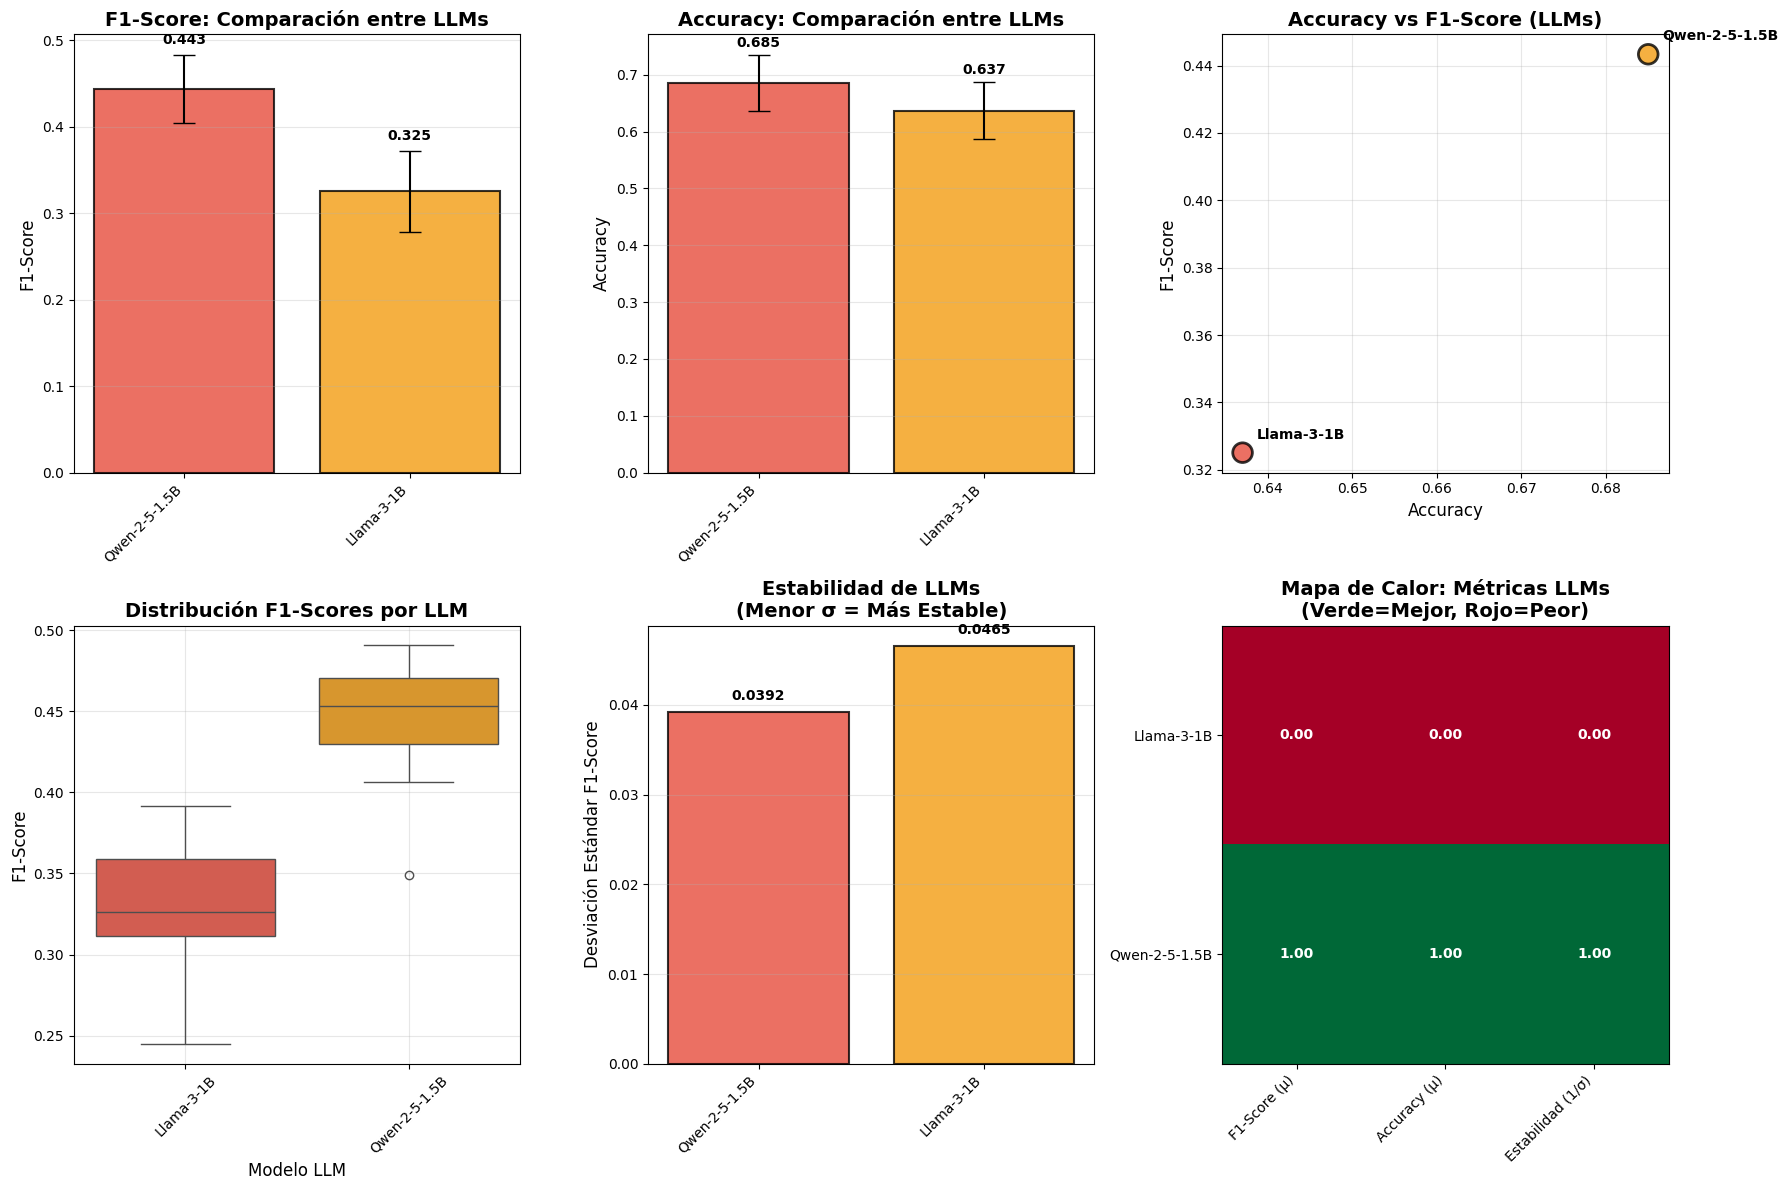

RESULTADOS COMPARATIVOS - MODELOS LLM ÚNICAMENTE

Tabla de Resultados:
------------------------------------------------------------
       Modelo  F1-Score (μ)  F1-Score (σ)  Accuracy (μ)  Accuracy (σ)  Particiones
Qwen-2-5-1.5B        0.4433        0.0392         0.685        0.0494           10
   Llama-3-1B        0.3251        0.0465         0.637        0.0498           10

MEJOR MODELO LLM:
   Modelo: Qwen-2-5-1.5B
   F1-Score: 0.4433 ± 0.0392
   Accuracy: 0.6850 ± 0.0494

DIFERENCIAS ENTRE LLMs:
   Diferencia F1-Score: 0.1182
   Diferencia Accuracy: 0.0480


In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Configurar estilo de gráficos
plt.style.use('default')
colors_llm = ['#E74C3C', '#F39C12', '#9B59B6', '#1ABC9C']

# Crear DataFrame solo con los resultados de LLMs
llm_comparison_data = []
for model_name, results in llm_results.items():
    llm_comparison_data.append({
        'Modelo': model_name,
        'F1-Score (μ)': results['f1_mean'],
        'F1-Score (σ)': results['f1_std'],
        'Accuracy (μ)': results['acc_mean'],
        'Accuracy (σ)': results['acc_std'],
        'Particiones': len(results['f1_scores'])
    })

llm_comparison_df = pd.DataFrame(llm_comparison_data)
llm_comparison_df_sorted = llm_comparison_df.sort_values('F1-Score (μ)', ascending=False)

# Crear figura con sub gráficos
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Comparación F1-Score entre LLMs
ax1 = axes[0, 0]
models_names = llm_comparison_df_sorted['Modelo']
f1_means = llm_comparison_df_sorted['F1-Score (μ)']
f1_stds = llm_comparison_df_sorted['F1-Score (σ)']

bars1 = ax1.bar(range(len(models_names)), f1_means, yerr=f1_stds,
                capsize=8, color=colors_llm[:len(models_names)],
                alpha=0.8, edgecolor='black', linewidth=1.5)

ax1.set_title('F1-Score: Comparación entre LLMs', fontsize=14, fontweight='bold')
ax1.set_ylabel('F1-Score', fontsize=12)
ax1.set_xticks(range(len(models_names)))
ax1.set_xticklabels(models_names, rotation=45, ha='right', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Agregar valores en las barras
for i, (bar, mean, std) in enumerate(zip(bars1, f1_means, f1_stds)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2., height + std + 0.01,
             f'{mean:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 2. Comparación Accuracy entre LLMs
ax2 = axes[0, 1]
acc_means = llm_comparison_df_sorted['Accuracy (μ)']
acc_stds = llm_comparison_df_sorted['Accuracy (σ)']

bars2 = ax2.bar(range(len(models_names)), acc_means, yerr=acc_stds,
                capsize=8, color=colors_llm[:len(models_names)],
                alpha=0.8, edgecolor='black', linewidth=1.5)

ax2.set_title('Accuracy: Comparación entre LLMs', fontsize=14, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_xticks(range(len(models_names)))
ax2.set_xticklabels(models_names, rotation=45, ha='right', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Agregar valores en las barras
for i, (bar, mean, std) in enumerate(zip(bars2, acc_means, acc_stds)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2., height + std + 0.01,
             f'{mean:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 3. Scatter plot: Accuracy vs F1-Score (solo LLMs)
ax3 = axes[0, 2]
scatter = ax3.scatter(llm_comparison_df['Accuracy (μ)'], llm_comparison_df['F1-Score (μ)'],
                      c=colors_llm[:len(llm_comparison_df)], alpha=0.8, s=200,
                      edgecolors='black', linewidth=2)

for i, modelo in enumerate(llm_comparison_df['Modelo']):
    ax3.annotate(modelo,
                 (llm_comparison_df.iloc[i]['Accuracy (μ)'], llm_comparison_df.iloc[i]['F1-Score (μ)']),
                 xytext=(10, 10), textcoords='offset points', fontsize=10, fontweight='bold')

ax3.set_xlabel('Accuracy', fontsize=12)
ax3.set_ylabel('F1-Score', fontsize=12)
ax3.set_title('Accuracy vs F1-Score (LLMs)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Distribución de F1-Scores por LLM
ax4 = axes[1, 0]
if len(llm_results) > 0:
    plot_data = []
    plot_labels = []

    for model_name, results in llm_results.items():
        if len(results['f1_scores']) > 0:
            plot_data.extend(results['f1_scores'])
            plot_labels.extend([model_name] * len(results['f1_scores']))

    if plot_data:
        box_df = pd.DataFrame({'Modelo': plot_labels, 'F1_Score': plot_data})
        box_plot = sns.boxplot(data=box_df, x='Modelo', y='F1_Score', ax=ax4,
                               palette=colors_llm[:len(llm_results)])
        ax4.set_title('Distribución F1-Scores por LLM', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Modelo LLM', fontsize=12)
        ax4.set_ylabel('F1-Score', fontsize=12)
        ax4.tick_params(axis='x', rotation=45)
        ax4.grid(True, alpha=0.3)

# 5. Comparación de estabilidad (Desviación estándar)
ax5 = axes[1, 1]
stability_data = llm_comparison_df_sorted['F1-Score (σ)']
bars5 = ax5.bar(range(len(models_names)), stability_data,
                color=colors_llm[:len(models_names)], alpha=0.8,
                edgecolor='black', linewidth=1.5)

ax5.set_title('Estabilidad de LLMs\n(Menor σ = Más Estable)', fontsize=14, fontweight='bold')
ax5.set_ylabel('Desviación Estándar F1-Score', fontsize=12)
ax5.set_xticks(range(len(models_names)))
ax5.set_xticklabels(models_names, rotation=45, ha='right', fontsize=10)
ax5.grid(True, alpha=0.3, axis='y')

# Agregar valores en las barras
for i, (bar, std) in enumerate(zip(bars5, stability_data)):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width() / 2., height + 0.001,
             f'{std:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 6. Mapa de calor de métricas LLM
ax6 = axes[1, 2]
# Crear matriz de métricas para mapa de calor
metrics_matrix = []
metric_names = ['F1-Score (μ)', 'Accuracy (μ)', 'Estabilidad (1/σ)']

for _, row in llm_comparison_df.iterrows():
    model_metrics = [
        row['F1-Score (μ)'],
        row['Accuracy (μ)'],
        1 / (row['F1-Score (σ)'] + 0.001)  # Invertir desviación para que mayor sea mejor
    ]
    metrics_matrix.append(model_metrics)

metrics_matrix = np.array(metrics_matrix)
# Normalizar métricas entre 0 y 1
metrics_normalized = (metrics_matrix - metrics_matrix.min(axis=0)) / (
        metrics_matrix.max(axis=0) - metrics_matrix.min(axis=0))

im = ax6.imshow(metrics_normalized, cmap='RdYlGn', aspect='auto')
ax6.set_xticks(range(len(metric_names)))
ax6.set_xticklabels(metric_names, rotation=45, ha='right', fontsize=10)
ax6.set_yticks(range(len(llm_comparison_df)))
ax6.set_yticklabels(llm_comparison_df['Modelo'], fontsize=10)
ax6.set_title('Mapa de Calor: Métricas LLMs\n(Verde=Mejor, Rojo=Peor)', fontsize=14, fontweight='bold')

# Agregar valores en el mapa de calor
for i in range(len(llm_comparison_df)):
    for j in range(len(metric_names)):
        text = ax6.text(j, i, f'{metrics_normalized[i, j]:.2f}',
                        ha="center", va="center", color="white", fontweight='bold')

plt.tight_layout()
plt.show()

# Mostrar tabla de resultados solo para LLMs
print("=" * 80)
print("RESULTADOS COMPARATIVOS - MODELOS LLM ÚNICAMENTE")
print("=" * 80)
print("\nTabla de Resultados:")
print("-" * 60)
print(llm_comparison_df_sorted.round(4).to_string(index=False))

# Identificar el mejor LLM
best_llm = llm_comparison_df_sorted.iloc[0]
print(f"\nMEJOR MODELO LLM:")
print(f"   Modelo: {best_llm['Modelo']}")
print(f"   F1-Score: {best_llm['F1-Score (μ)']:.4f} ± {best_llm['F1-Score (σ)']:.4f}")
print(f"   Accuracy: {best_llm['Accuracy (μ)']:.4f} ± {best_llm['Accuracy (σ)']:.4f}")

# Análisis de diferencias entre LLMs
if len(llm_comparison_df) > 1:
    f1_diff = llm_comparison_df_sorted.iloc[0]['F1-Score (μ)'] - llm_comparison_df_sorted.iloc[1]['F1-Score (μ)']
    acc_diff = llm_comparison_df_sorted.iloc[0]['Accuracy (μ)'] - llm_comparison_df_sorted.iloc[1]['Accuracy (μ)']

    print(f"\nDIFERENCIAS ENTRE LLMs:")
    print(f"   Diferencia F1-Score: {f1_diff:.4f}")
    print(f"   Diferencia Accuracy: {acc_diff:.4f}")

De los resultados finales de la parte 2, podemos ver que para el uso de LLMs, en este caso nuestros dos modelos de bajo número de parametros podemos ver que el ganador general fue el modelo de Qwen de 1,5 billones de parametros, esto demuestra que su mayor número de parametros ayudo a obtener el resultado, ya que se realizaron varias pruebas y consistentemente se obtenia un F1 Score de mayor a 0,4 con una mejora mayor al 35% respecto a Llama. El accuracy muestra un resultado muy similar con apenas una mejoria de 7% aproximadamente.

En cuanto a la estabilidad del modelo, se muestra que Qwen tiene más de 18% más de estabilidad en su F1 Score. En las desviaciones son muy similares y tiene una dispersion parecida.

Al llevar a cabo la experimentacion se utilizaron distintos prompts y modelos, en cuanto a los modelos se obtuvo que entre más parametros se puede tener un mejor rendimiento. Sobre el prompt este es crítico para el exito debido a que si se hacía un prompt no adecuado podia a llegar a tener muchos errores, ya que los LLM no daban como salida un resultado claro y empezaban a dar descripciones largas o alucinaciones por lo que un prompt acertado genera la diferencia, otro prompt utilizados generaban F1 Score de alrededor de 0,2, por lo que un buen prompt está muy relacionado a que puedan entender mejor la tarea.

En general estos modelos no presentan muy buenos resultados, ya que su F1 Score es bajo, muestran un accuracy moderado pero no suficiente para considerarlo una buena solucion. Sin embargo, también no tienen resultados tan bajos a pesar de su poco número de parametros y al existir actualmente modelos con una gran cantidad de parametros hasta 600 billones o inclusive más disponibles para uso comercial, es posible que diversos modelos puedan tener una mejora exponencial.

Es muy posible que ajustar el prompt y modelos de mejor tamaño, entrenados en la tarea de spam o inclusive por medio de algún finetuning se podria generar un resultado óptimo, por lo que el espacio de mejora es grande.

# 3. (40 puntos) Compare los resultados entre los 4 modelos entrenados, y argumente ventajas y desventajas de cada uno con respecto a los resultados logrados.

PUNTO 3: ANÁLISIS COMPARATIVO COMPLETO DE LOS 4 MODELOS ENTRENADOS

TABLA COMPARATIVA COMPLETA:
------------------------------------------------------------------------------------------------------------------------
                    Modelo         Tipo  F1_Mean  F1_Std  Acc_Mean  Estabilidad Complejidad
Red Neuronal V1 (Profunda) Red Neuronal   0.9665  0.0066    0.9911       0.0066        Alta
  Red Neuronal V2 (Simple) Red Neuronal   0.9595  0.0091    0.9892       0.0091       Media
             Qwen-2-5-1.5B          LLM   0.4433  0.0392    0.6850       0.0392    Muy Alta
                Llama-3-1B          LLM   0.3251  0.0465    0.6370       0.0465    Muy Alta

RANKING DE RENDIMIENTO:
    Red Neuronal V1 (Profunda): F1=0.9665±0.0066
    Red Neuronal V2 (Simple): F1=0.9595±0.0091
    Qwen-2-5-1.5B: F1=0.4433±0.0392
    Llama-3-1B: F1=0.3251±0.0465

ANÁLISIS POR CATEGORÍAS:
------------------------------------------------------------
MEJOR RENDIMIENTO GENERAL: Red Neuronal V1 (Pr

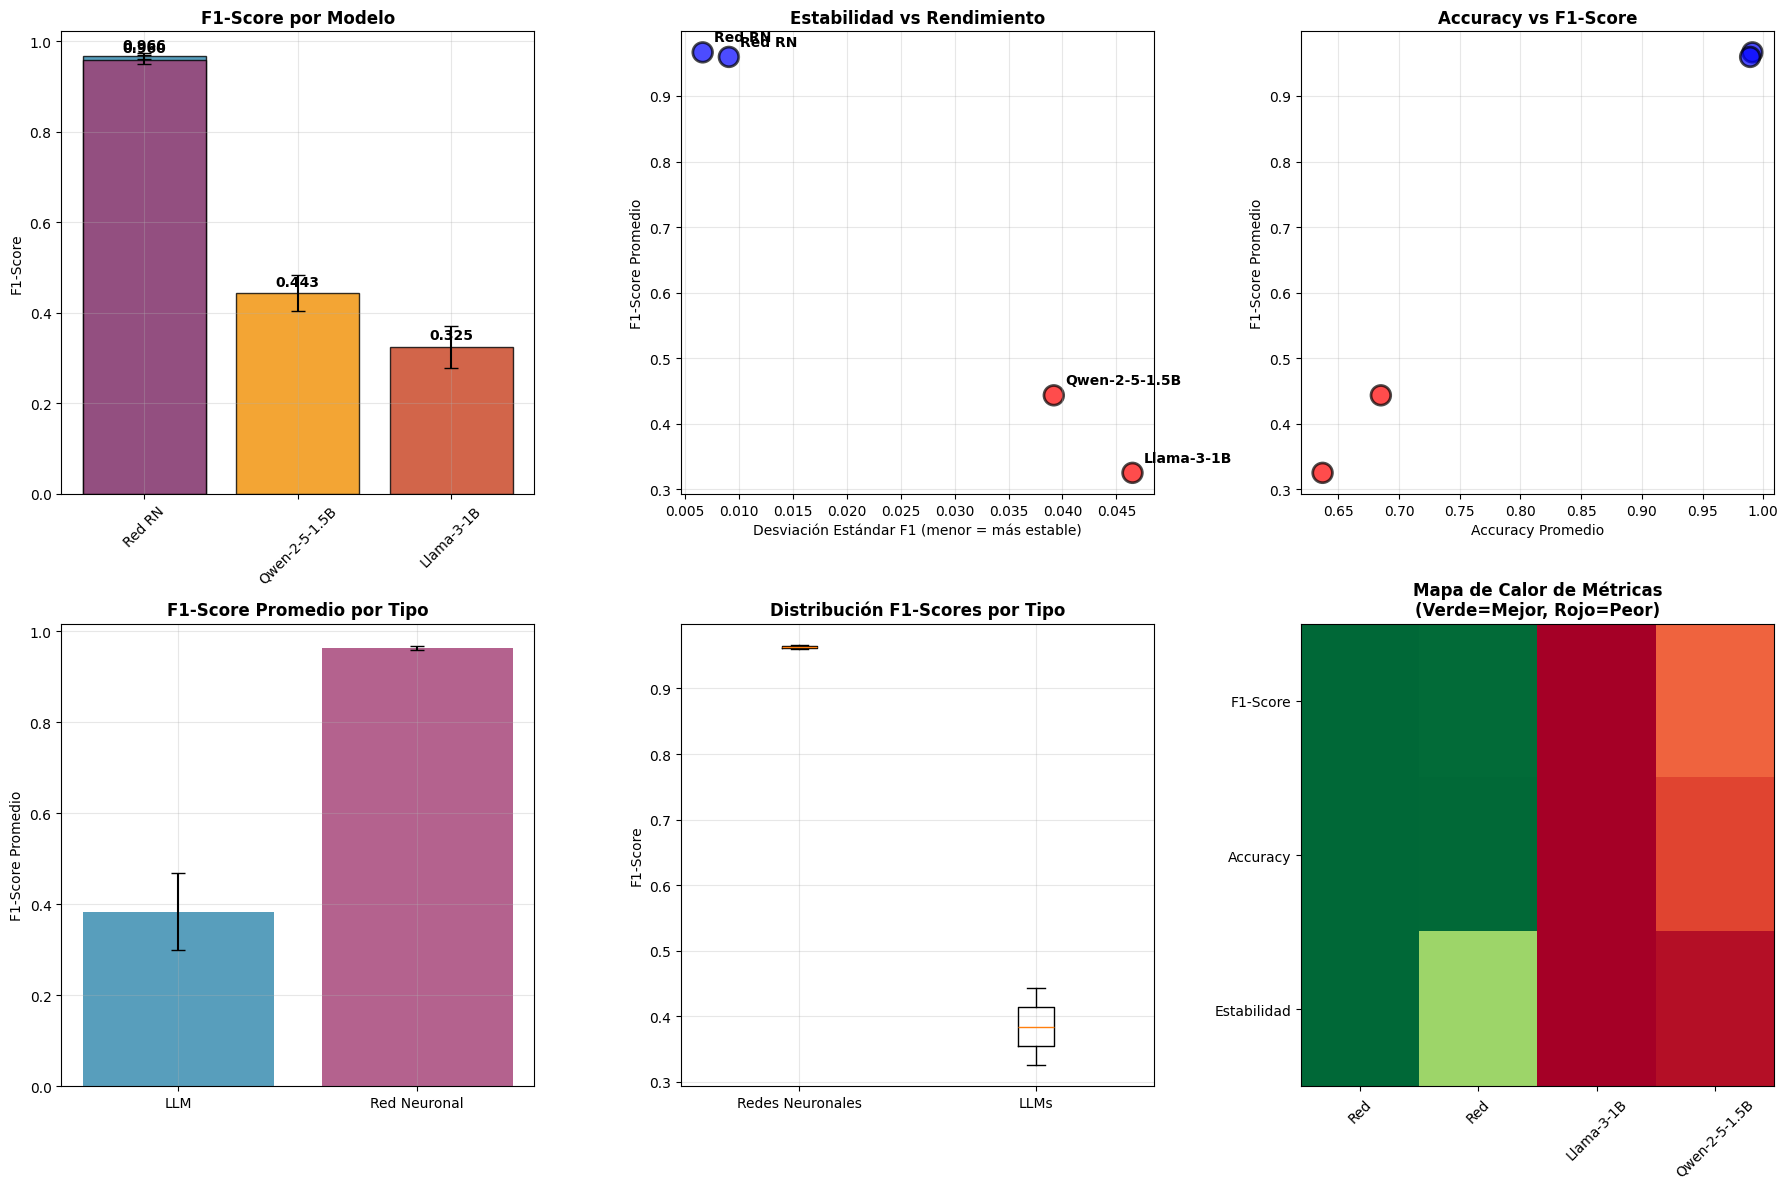

In [79]:
print("=" * 100)
print("PUNTO 3: ANÁLISIS COMPARATIVO COMPLETO DE LOS 4 MODELOS ENTRENADOS")
print("=" * 100)

# Recopilar todos los resultados
all_models_comparison = []

# Agregar resultados de redes neuronales
all_models_comparison.append({
    'Modelo': 'Red Neuronal V1 (Profunda)',
    'Tipo': 'Red Neuronal',
    'Arquitectura': '4 capas (768→512→256→128→1)',
    'F1_Mean': stats_v1['f1_mean'],
    'F1_Std': stats_v1['f1_std'],
    'Acc_Mean': stats_v1['acc_mean'],
    'Acc_Std': stats_v1['acc_std'],
    'Tiempo_Entrenamiento': stats_v1['time_mean'],
    'Particiones': 10,
    'Parametros_Aprox': '~2M parámetros de clasificador + BERT embeddings',
    'Complejidad': 'Alta',
    'Estabilidad': stats_v1['f1_std']
})

all_models_comparison.append({
    'Modelo': 'Red Neuronal V2 (Simple)',
    'Tipo': 'Red Neuronal',
    'Arquitectura': '3 capas (768→256→64→1)',
    'F1_Mean': stats_v2['f1_mean'],
    'F1_Std': stats_v2['f1_std'],
    'Acc_Mean': stats_v2['acc_mean'],
    'Acc_Std': stats_v2['acc_std'],
    'Tiempo_Entrenamiento': stats_v2['time_mean'],
    'Particiones': 10,
    'Parametros_Aprox': '~500K parámetros de clasificador + BERT embeddings',
    'Complejidad': 'Media',
    'Estabilidad': stats_v2['f1_std']
})

# Agregar resultados de LLMs
for model_name, results in llm_results.items():
    all_models_comparison.append({
        'Modelo': f'{model_name}',
        'Tipo': 'LLM',
        'Arquitectura': 'Transformer autoregresivo',
        'F1_Mean': results['f1_mean'],
        'F1_Std': results['f1_std'],
        'Acc_Mean': results['acc_mean'],
        'Acc_Std': results['acc_std'],
        'Tiempo_Entrenamiento': 'N/A (pre-entrenado)',
        'Particiones': n_evaluation_splits,
        'Parametros_Aprox': '3B+' if 'Qwen' in model_name else 'Variable',
        'Complejidad': 'Muy Alta',
        'Estabilidad': results['f1_std']
    })

# Crear DataFrame para análisis
comparison_df = pd.DataFrame(all_models_comparison)
comparison_df_sorted = comparison_df.sort_values('F1_Mean', ascending=False)

print("\nTABLA COMPARATIVA COMPLETA:")
print("-" * 120)
display_cols = ['Modelo', 'Tipo', 'F1_Mean', 'F1_Std', 'Acc_Mean', 'Estabilidad', 'Complejidad']
print(comparison_df_sorted[display_cols].round(4).to_string(index=False))

print(f"\nRANKING DE RENDIMIENTO:")
for i, (_, row) in enumerate(comparison_df_sorted.iterrows(), 1):
    medal = "" if i == 1 else "" if i == 2 else "" if i == 3 else f""
    print(f"   {medal} {row['Modelo']}: F1={row['F1_Mean']:.4f}±{row['F1_Std']:.4f}")

# Análisis por categorías
print(f"\nANÁLISIS POR CATEGORÍAS:")
print("-" * 60)

# Mejor rendimiento general
best_model = comparison_df_sorted.iloc[0]
print(f"MEJOR RENDIMIENTO GENERAL: {best_model['Modelo']}")
print(f"   • F1-Score: {best_model['F1_Mean']:.4f} ± {best_model['F1_Std']:.4f}")
print(f"   • Accuracy: {best_model['Acc_Mean']:.4f}")

# Más estable (menor desviación estándar)
most_stable = comparison_df.loc[comparison_df['Estabilidad'].idxmin()]
print(f"\nMÁS ESTABLE: {most_stable['Modelo']}")
print(f"   • Desviación F1: {most_stable['Estabilidad']:.4f}")
print(f"   • F1 promedio: {most_stable['F1_Mean']:.4f}")

# Análisis por tipo de modelo
type_analysis = comparison_df.groupby('Tipo').agg({
    'F1_Mean': ['mean', 'max', 'min'],
    'Acc_Mean': ['mean', 'max', 'min'],
    'Estabilidad': 'mean'
}).round(4)

print(f"\nANÁLISIS POR TIPO DE MODELO:")
print(type_analysis)

# Crear visualizaciones comparativas
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Rendimiento F1 por modelo
ax1 = axes[0, 0]
models_short = [name.split()[0] + (' RN' if 'Red' in name else '') for name in comparison_df_sorted['Modelo']]
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
bars = ax1.bar(models_short, comparison_df_sorted['F1_Mean'],
               yerr=comparison_df_sorted['F1_Std'], capsize=5,
               color=colors[:len(models_short)], alpha=0.8, edgecolor='black')
ax1.set_title('F1-Score por Modelo', fontweight='bold')
ax1.set_ylabel('F1-Score')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Agregar valores en las barras
for bar, mean in zip(bars, comparison_df_sorted['F1_Mean']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2., height + 0.01,
             f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Estabilidad vs Rendimiento
ax2 = axes[0, 1]
scatter = ax2.scatter(comparison_df['Estabilidad'], comparison_df['F1_Mean'],
                      s=200, alpha=0.7,
                      c=['blue' if 'Red' in x else 'red' for x in comparison_df['Modelo']],
                      edgecolors='black', linewidth=2)
ax2.set_xlabel('Desviación Estándar F1 (menor = más estable)')
ax2.set_ylabel('F1-Score Promedio')
ax2.set_title('Estabilidad vs Rendimiento', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Agregar etiquetas
for i, modelo in enumerate(comparison_df['Modelo']):
    label = modelo.split()[0] + (' RN' if 'Red' in modelo else '')
    ax2.annotate(label,
                 (comparison_df.iloc[i]['Estabilidad'], comparison_df.iloc[i]['F1_Mean']),
                 xytext=(8, 8), textcoords='offset points', fontweight='bold')

# 3. Accuracy vs F1-Score
ax3 = axes[0, 2]
ax3.scatter(comparison_df['Acc_Mean'], comparison_df['F1_Mean'],
            s=200, alpha=0.7,
            c=['blue' if 'Red' in x else 'red' for x in comparison_df['Modelo']],
            edgecolors='black', linewidth=2)
ax3.set_xlabel('Accuracy Promedio')
ax3.set_ylabel('F1-Score Promedio')
ax3.set_title('Accuracy vs F1-Score', fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Comparación por tipo de modelo
ax4 = axes[1, 0]
type_means = comparison_df.groupby('Tipo')['F1_Mean'].mean()
type_stds = comparison_df.groupby('Tipo')['F1_Mean'].std().fillna(0)
bars = ax4.bar(type_means.index, type_means.values,
               yerr=type_stds.values, capsize=5,
               color=['#2E86AB', '#A23B72'], alpha=0.8)
ax4.set_title('F1-Score Promedio por Tipo', fontweight='bold')
ax4.set_ylabel('F1-Score Promedio')
ax4.grid(True, alpha=0.3)

# 5. Distribución de F1-Scores
ax5 = axes[1, 1]
rn_f1_scores = [stats_v1['f1_mean'], stats_v2['f1_mean']]
llm_f1_scores = [results['f1_mean'] for results in llm_results.values()]
ax5.boxplot([rn_f1_scores, llm_f1_scores], labels=['Redes Neuronales', 'LLMs'])
ax5.set_title('Distribución F1-Scores por Tipo', fontweight='bold')
ax5.set_ylabel('F1-Score')
ax5.grid(True, alpha=0.3)

# 6. Mapa de calor de métricas normalizadas
ax6 = axes[1, 2]
metrics_for_heatmap = comparison_df[['F1_Mean', 'Acc_Mean']].copy()
# Normalizar métricas (invertir estabilidad para que mayor sea mejor)
metrics_for_heatmap['Estabilidad_Inv'] = 1 / (comparison_df['Estabilidad'] + 0.001)
metrics_normalized = (metrics_for_heatmap - metrics_for_heatmap.min()) / (
        metrics_for_heatmap.max() - metrics_for_heatmap.min())

im = ax6.imshow(metrics_normalized.T, cmap='RdYlGn', aspect='auto')
ax6.set_xticks(range(len(comparison_df)))
ax6.set_xticklabels([name.split()[0] for name in comparison_df['Modelo']], rotation=45)
ax6.set_yticks(range(len(metrics_normalized.columns)))
ax6.set_yticklabels(['F1-Score', 'Accuracy', 'Estabilidad'])
ax6.set_title('Mapa de Calor de Métricas\n(Verde=Mejor, Rojo=Peor)', fontweight='bold')

plt.tight_layout()
plt.show()

Sobre los resultados generales, podemos observar de la tabla y graficos de la celda anterior como las redes neuronales realizadas, simples y profundas obtienen un resultado mucho mayor a utilizar uno de los LLMs extraidos de Hugging Face por una gran diferencia.

Las redes neuronales contienen tres y dos capas, y obtienen resultados muy buenos con un F1 Score promedio mayor a 0,95 y una desviacion muy baja, teniendo resultados muy consistentes y un promedio de accuracy mayor a 98%, mientras que los LLMs obtuvieron resultados de 0,32 y 0,44 en su F1 Score promedio y un accuracy de 63% y 68%, teniendo una diferencia mucho mayor, además de una desviacion más grande demostrando una consistencia baja en sus resultados.

El resultado mayor lo obtuvo la red neuronal V1 por un margen muy pequeño con respecto a la arquitectura V2. A pesar de los LLMs estar preentrenados y tener una gran cantidad de parametros demuestran que aún necesitan mayor capacidad en si mismos para un mejor razonamiento o un entrenamiento específico en la tarea de clasificacion de spam para poder generar resultados buenos, ya que las redes neuronales creadas son muy simples, pero tienen la ventaja de ser expuestas solamente a esta tarea, mientras que los LLMs utilizados fueron entrenados de una manera general y no exclusivamente para estas tareas. Lo que demuestra también que el número de parametros no indica que sean capaces de atacar una tarea de la misma manera que una red entrenada especificamente para ese trabajo específico como clasificacion de spam.

En resumen, en cuanto a ventajas y desventajas se determinan los siguientes puntos.

*Arquitecturas de Redes Neuronales Base*

Ventajas:

- Excelente en tareas específicas, demostrando buen rendimiento y poca complejidad a nivel general. En la tarea de clasificacion de spam, logro realizarlo de manera satisfactoria con un dataset pequeño.
- Entrenamiento un poco más rapido debido a estar enfocado en una tarea y datasets dedicados a solo ese proposito.
- Libre de dependencias al tener la posibilidad de ser servido en un servidor local sin necesidad de terceros.
- La seguridad de los datos es garantizado al poder tener un modelo propio y no tener que enviar datos a otros lugares.
- Personalizacion de toda la arquitectura, optimizadores, capas, funciones de perdida, algoritmos de parada, entre otros.
- No es necesario tener muchas capas ni complejidad en las mismas para obtener resultados optimos con un buen dataset como en este caso, aunque problemas mas complejos siempre va ser necesario datasets mucho mas grandes.

Desventajas:

- Al ser entrenado solamente en una tarea no va a poder realizar un buen trabajo en otros problemas, si se necesita entrenar para distintas tareas su costo computacional, datasets y complejidad en sus capas aumentaria en un nivel alto.
- Ocupa datasets especializados, algo escaso a nivel de codigo libre.
- Se necesita entrenar desde cero, lo que requiere tiempo computacional y recursos con costos elevados dependiendo el tamaño de la tarea,
- Cambios en su arquitectura van a requerir nuevos entrenamientos.
- Se necesitan recursos humanos expertos en distintas áreas para construir un modelo y plataforma adecuada al soporte y mejoramiento del modelo.
- Desarrollo y iteraciones lentas

*LLMs*

Ventajas:

- No es necesario tener la capacidad computacional para correrlos, pero existe la posibilidad de correrlos localmente.
- Generaliza moderadamente en distintas tareas sin finetuning con resultados moderados a buenos.
- Diversidad de modelos para distintas tareas a nivel libre y comercial.
- Capacidad de añadir contexto de un dominio específico por ejemplo con el uso de RAG
- Inversion inicial pequeña
- Mejoras en el modelo continua por parte del proveedor

Desventajas:

- No genera buenos resultados en tareas específicas, en nuestro caso un F1 Score que no llegaba al 0,5
- Costo de finetuning a un LLM es alto
- La inferencia genera un costo alto por cada token o llamada a su API
- Riesgo de fuga de datos al tener que enviarlos a un proveedor externo
- Muchos LLM no tienen filtros de calidad y podrian alucinar o convencer de las respuestas incorrectas.
- Son de caja negra y no es posible muchas veces ver cuál fue su razonamiento o funcionamiento interno.

En conclusion, para este quiz las redes neuronales se presentan como la mejor opcion debido a sus resultados excelentes, requisitos de recursos y tiempo de computacion moderados, libre de cualquier limitacion o dependencia externa, además de la capacidad de modificar, observar y depurar cualquier anomalia presentada en sus resultados de manera directa, cosas que los LLM no es posible en este momento para los modelos utilizados.

Cabe recalcar que modelos más grandes como DeepSeek, GPT-5, Claude o Gemini podrian proveer mejores resultados, sin embargo, cuestiones como costo, depuracion, seguridad de los datos y finetuning son actividades dificultosas de realizar en un LLM y el costo/beneficio podria ser determinante para solamente usar una red neuronal propia adecuada para la tarea a largo plazo, si se cuenta con el dataset, talento y recurso computacional.

# 4. (10 puntos) Con respecto a la presentacion del Dr. Thijs, y los resultados logrados, comente las distintas tecnicas de ajustar los LLMs para resolver un problema especifico.

El Dr. Thijs van Ede, presento distintas tecnicas como lo fue su proyecto DeepCase y el Terminator que utiliza RAG.

En cuanto a Deep Case, este utiliza una combinacion de tecnicas como semi-supervised deep learning, busqueda por similitud y clustering.

Esta propuesta tiene distintas tecnicas ingeniosas debido a que primero utiliza un algoritmo que combina eventos generados por detectores de manera cronologica, después se utiliza un elemento llamado el "Context Builder" para poder identificar todos los eventos relevantes y construir un vector, todo esto por medio de una red neuronal recurrente entrenada para este efecto que toma tecnicas del área de NLP, este utiliza el concepto de attention para que la red neuronal se enfoque en solo las partes relevantes de una secuencia en su entrada, este attention puede usarse para comparar la relevancia de eventos en el contexto de las secuencias de eventos de seguridad. Este ContextBuilder está hecho no para predecir eventos siguientes, sino para predecir el evento de seguridad que desencadeno la alerta y poder comprobar si ese conjunto de eventos correctamente son el contexto para la alerta y poder utilizar este vector de atencion correctamente, si no se pasa a un modo manual donde se le indica a un operador humano del hecho para realizar un analisis manual. Esta parte del context builder utiliza una arquitectura encoder-decoder en combinacion con el mecanismo de attention para poder generar lo que es un vector de contexto.

Finalmente, otra pieza importante en DeepCase es el "Interpreter" que tiene como tarea comparar diferentes secuencias con el fin de analizar si existen valores de attention similares y poder asi interpretar que pueden tratarse de la misma manera por los operadores de ciberseguridad. En esta parte se genera un cluster de secuencias similares por medio de una funcion de distancia. En esta parte de clustering se determinan inicialmente por un operador si contienen eventos benignos o maliciosos con el fin de ser clasificados y guardados posteriormente para ser usados en el modo semisupervisado y tomar las acciones correctas si una nueva secuencia es similar a uno previo en algún cluster.

Como se observa de DeepCase se utiliza un tipo de red neuronal especial como lo es la recurrente, algoritmos de programacion para recopilar los eventos, el uso de clustering y funciones de similitud para poder generar un producto que clasifica eventos de seguridad maliciosos. De esto podemos observar que no necesariamente se necesita solo entrenar una red neuronal y esperar a que se resuelva el problema, sino que existen muchas tecnicas que pueden ser complementarias o solamente una parte de un sistema mucho más grande para poder mejorar un proceso, como lo fue en este caso de clasificacion de eventos sospechosos partiendo de eventos de dispositivos.

Otro trabajo del Dr fue el RAG de Terminator, en este caso si se utilizan LLMs comunes pero con un contexto añadido de una manera más inteligente, ya que se utilizó la tecnica de RAG que utiliza bases de datos vectoriales, funciones de busqueda por similitud y la adicion inteligente de contexto a un LLM preentrenado como podria ser Qwen, Chat GPT o Llama para poder generar un sistema que con el contexto añadido puede realizar una tarea.

En el caso de terminator podemos ver como algoritmos vectoriales para recuperar contexto similar a la entrada y la adicion de contexto a un LLM puede generar resultados interesantes sin necesidad de entrenar un LLM desde cero o realizar un finetuning, tecnicas que pueden ser costosas. En el caso de terminator por medio de la adicion de herramientas de computacion y documentacion de las mismas es capaz de generar comandos que podrian mitigar un ataque de manera automatica sin necesidad de ser expertos en esas herramientas si no solo con la interpretacion de un ataque, la recoleccion de herramientas y documentos relacionados a ese tipo de ataque y dando como salida un comando basado en el uso de esas herramientas.

En general con base en los resultados del quiz y la presentacion del Dr. Thijs podemos ver como distintas redes neuronales, algoritmos vectoriales y tecnicas como RAG en LLMs abren la posibilidad de utilizar modelos de distintas maneras para lograr los objetivos de una tarea específica con distintas ventajas y desventajas en cada uno, y no solo utilizar una tecnica en sí para un mismo problema, si no que se pueden utilizar como complemento en un flujo de tecnicas para un problema a resolver.

